<center>
<img src='stock_market.jpg' alt='' title='Wallpaper' width="70%" height="20%"/>
</center>

<h1><center>Stock Index Visualization & Price Prediction<br>
    <font size=4.5>
        <i>
            Made by: <a href="https://www.linkedin.com/in/hai-vu/">Hai Vu</a>
        </i>
    </font>

## Project Overview

This project focuses on Stock indices, which are measures of the performance of a group of stocks that represent a particular market or sector. A stock index is calculated based on the performance of a selected group of stocks, and it provides a snapshot of the overall performance of the market or sector that the index represents. In this project, my main goal is to:

* Visualize closing prices and volumes of major stock indices around the world, where the list of indices is based on [Yahoo Finance](https://finance.yahoo.com/world-indices/)
* Construct the [Efficient Frontier](https://www.investopedia.com/terms/e/efficientfrontier.asp) curve through random sampling and simulating performances of portfolios, each of which consists of different indices
* Generate price predictions for stock indices based on historical closing prices. The neural network with [Multi-layer Perceptron regressor (MLP Regressor)](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) from the Sklearn library was used to construct the prediction model

<b> [Visit the Stock Index webapp on Streamlit here!](https://namhaivu173-stock-index-app-indices-app-6amttx.streamlit.app/) </b>

## Table of Contents
<a id='TOC'></a>

- <b>[I. Extract Stock Index Price & Preprocess Data](#extract)</b>
- <b>[II. Stock Index Historical Data Visualization](#visualization)</b>
- <b>[III. Efficient Frontier Simulation](#simulation)</b>
- <b>[IV. Stock Index Price Prediction](#prediction)</b>
- <b>[V. Code References](#references)</b>


In [113]:
# Import libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import requests
import time
import pytz
import random
import math
import statistics
from pylab import *
from collections import Counter
from dateutil.relativedelta import relativedelta
import plotly as ply
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import streamlit as st
import scipy
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


## I. Extract Index Ticker Price
<a id='extract'></a>

In [11]:
# Get names of major world indices from yahoo (https://finance.yahoo.com/world-indices)
def url_indices(url, download=False):
    r = requests.get(url)
    df_world = pd.read_html(r.text)
    world_idx = df_world[0]
    
    if download==True:
        world_idx.to_csv("World_Indices_Yahoo.csv", index=False)
        
    return world_idx

# Save file in case link fails
world_idx = url_indices('https://finance.yahoo.com/world-indices')
world_idx.head()

Symbol                          Name  Last Price  Change % Change    Volume  \
0  ^GSPC                       S&P 500     4146.22   54.27   +1.33%    2.197B   
1   ^DJI  Dow Jones Industrial Average    34029.69  383.19   +1.14%  277.238M   
2  ^IXIC              NASDAQ Composite    12166.27  236.93   +1.99%    4.348B   
3   ^NYA           NYSE COMPOSITE (DJ)    15630.89  129.96   +0.84%         0   
4   ^XAX     NYSE AMEX COMPOSITE INDEX     4376.91   13.79   +0.32%         0   

   Intraday High/Low  52 Week Range  Day Chart  
0                NaN            NaN        NaN  
1                NaN            NaN        NaN  
2                NaN            NaN        NaN  
3                NaN            NaN        NaN  
4                NaN            NaN        NaN

In [12]:
# Get dict of index names and tickers
ticker_name = dict(zip(world_idx['Symbol'],world_idx['Name']))
ticker_name['^NZ50'] = 'S&P/NZX 50 INDEX GROSS'
ticker_name

{'^GSPC': 'S&P 500',
 '^DJI': 'Dow Jones Industrial Average',
 '^IXIC': 'NASDAQ Composite',
 '^NYA': 'NYSE COMPOSITE (DJ)',
 '^XAX': 'NYSE AMEX COMPOSITE INDEX',
 '^BUK100P': 'Cboe UK 100',
 '^RUT': 'Russell 2000',
 '^VIX': 'CBOE Volatility Index',
 '^FTSE': 'FTSE 100',
 '^GDAXI': 'DAX PERFORMANCE-INDEX',
 '^FCHI': 'CAC 40',
 '^STOXX50E': 'ESTX 50 PR.EUR',
 '^N100': 'Euronext 100 Index',
 '^BFX': 'BEL 20',
 'IMOEX.ME': 'MOEX Russia Index',
 '^N225': 'Nikkei 225',
 '^HSI': 'HANG SENG INDEX',
 '000001.SS': 'SSE Composite Index',
 '399001.SZ': 'Shenzhen Index',
 '^STI': 'STI Index',
 '^AXJO': 'S&P/ASX 200',
 '^AORD': 'ALL ORDINARIES',
 '^BSESN': 'S&P BSE SENSEX',
 '^JKSE': 'IDX COMPOSITE',
 '^KLSE': 'FTSE Bursa Malaysia KLCI',
 '^NZ50': 'S&P/NZX 50 INDEX GROSS',
 '^KS11': 'KOSPI Composite Index',
 '^TWII': 'TSEC weighted index',
 '^GSPTSE': 'S&P/TSX Composite index',
 '^BVSP': 'IBOVESPA',
 '^MXX': 'IPC MEXICO',
 '^IPSA': 'S&P/CLX IPSA',
 '^MERV': 'MERVAL',
 '^TA125.TA': 'TA-125',
 '^CASE3

In [13]:
# Function for streamlit cache
def load_data(file):
    df = pd.read_csv(file)
    return df

load_data('Indices_Description.csv').head()

Stock Index Ticker Symbol  \
0                       S&P 500         ^GSPC   
1  Dow Jones Industrial Average          ^DJI   
2              NASDAQ Composite         ^IXIC   
3           NYSE COMPOSITE (DJ)          ^NYA   
4     NYSE AMEX COMPOSITE INDEX          ^XAX   

                                         Description  
0  A market-capitalization-weighted index of 500 ...  
1  A price-weighted index of 30 large, publicly t...  
2  A market-capitalization-weighted index of all ...  
3  A market-capitalization-weighted index of all ...  
4  A market-capitalization-weighted index of all ...

In [14]:
# create random subset of a dictionary (in case there are too many indices to plot)
def create_random_dict(input_dict, num_pairs, random_seed=99):
    np.random.seed(random_seed)
    keys = np.random.choice(list(input_dict.keys()), num_pairs, replace=False)
    return {k: input_dict[k] for k in keys}

# ticker_name2 = {**ticker_name, **stock_name}
# ticker_name2 = create_random_dict(ticker_name, len(ticker_name) // 2)

In [15]:
date_now = int(datetime.datetime.now(pytz.utc).strftime('%d'))
month_now = int(datetime.datetime.now(pytz.utc).strftime('%m'))
year_now = int(datetime.datetime.now(pytz.utc).strftime('%Y'))

time_start = datetime.date(year=min(2010,year_now-10), month=1, day=1) # Take first day and month of 10 years ago / or take first day of 2010
#time_start = datetime.date(year=2014, month=1, day=1)
time_end = datetime.date(year=year_now, month=month_now, day=1) # Take first day of month of today's date

print(time_start)
print(time_end)

2010-01-01
2023-04-01


In [16]:
# Extract the risk free rate (10-yr treasury yield)
def get_riskfree():
    treasury_10y = yf.Ticker('^TNX')
    treasury_10y = treasury_10y.history(period='max') # Get annual risk free rate
    treasury_10y.index = pd.to_datetime(treasury_10y.index.strftime("%Y-%m-%d"))
    treasury_10y = treasury_10y[treasury_10y.index <= str(time_end)]['Close'].tail(1).iloc[0]
    treasury_10y = treasury_10y/100
    return treasury_10y

treasury_10y = get_riskfree()
treasury_10y

0.0349399995803833

In [17]:
# All treasury rates
df_treasury = yf.download(['^IRX', '^TNX', '^TYX'], period='1d', start=time_start, end=time_end)['Close']
df_treasury.columns = ['1-Year', '10-Year', '20-Year']
df_treasury.head()

[*********************100%***********************]  3 of 3 completed


1-Year  10-Year  20-Year
Date                                
2010-01-04   0.055    3.841    4.660
2010-01-05   0.060    3.755    4.593
2010-01-06   0.045    3.808    4.671
2010-01-07   0.045    3.822    4.689
2010-01-08   0.040    3.808    4.695

In [18]:
%%time
# Extract all major tickers symbol, closing price and volume
def get_tickers(tickers, start=time_start, end=time_end):
    ticker_list = []
    for idx in tickers:
        ticker_data = yf.Ticker(idx)
        df_ticker = ticker_data.history(period='1d', start=start, end=end)
        df_ticker['Ticker'] = idx
        df_ticker = df_ticker[['Ticker','Close','Volume']]
        ticker_list.append(df_ticker)

    # Store data in a list
    df_tickers = pd.concat(ticker_list, axis=0).reset_index()

    # Convert Date column to datetime
    df_tickers['Date'] = pd.to_datetime(pd.to_datetime(df_tickers['Date'], utc=True).dt.strftime('%Y-%m-%d'))
    return df_tickers

# Extract tickers' prices
df_tickers = get_tickers(ticker_name.keys())

# Show dataframe
df_tickers.head()

^CASE30: No data found for this date range, symbol may be delisted
Wall time: 13.3 s


Date Ticker        Close        Volume
0 2010-01-04  ^GSPC  1132.989990  3.991400e+09
1 2010-01-05  ^GSPC  1136.520020  2.491020e+09
2 2010-01-06  ^GSPC  1137.140015  4.972660e+09
3 2010-01-07  ^GSPC  1141.689941  5.270680e+09
4 2010-01-08  ^GSPC  1144.979980  4.389590e+09

In [19]:
# Show info of df
df_tickers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111275 entries, 0 to 111274
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    111275 non-null  datetime64[ns]
 1   Ticker  111275 non-null  object        
 2   Close   111275 non-null  float64       
 3   Volume  111275 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 3.4+ MB


In [20]:
# Show time range of data
print(min(df_tickers['Date']))
print(max(df_tickers['Date']))

2010-01-03 00:00:00
2023-03-31 00:00:00


In [21]:
# Number of indices
len(df_tickers['Ticker'].unique())

35

In [22]:
# Define region for each index
region_idx = {
  'US & Canada' : ['^GSPC', '^DJI','^IXIC', '^RUT','^GSPTSE','^NYA','^XAX','^VIX','^CASE30','^JN0U.JO'],
  'South & Latin America' : ['^BVSP', '^MXX', '^IPSA'], #'^MERV'],
  'ASEAN': ['^STI', '^JKSE', '^KLSE'],
  'Oceania & Middle East': ['^AXJO', '^NZ50', '^AORD'],
  'Other Asia': ['^N225', '^HSI', '000001.SS', '399001.SZ', '^TWII', '^KS11', '^BSESN', '^TA125.TA'],
  'Europe' : ['^FTSE', '^GDAXI', '^FCHI', '^STOXX50E','^N100', '^BFX', '^BUK100P','IMOEX.ME']
}

region_idx

{'US & Canada': ['^GSPC',
  '^DJI',
  '^IXIC',
  '^RUT',
  '^GSPTSE',
  '^NYA',
  '^XAX',
  '^VIX',
  '^CASE30',
  '^JN0U.JO'],
 'South & Latin America': ['^BVSP', '^MXX', '^IPSA'],
 'ASEAN': ['^STI', '^JKSE', '^KLSE'],
 'Oceania & Middle East': ['^AXJO', '^NZ50', '^AORD'],
 'Other Asia': ['^N225',
  '^HSI',
  '000001.SS',
  '399001.SZ',
  '^TWII',
  '^KS11',
  '^BSESN',
  '^TA125.TA'],
 'Europe': ['^FTSE',
  '^GDAXI',
  '^FCHI',
  '^STOXX50E',
  '^N100',
  '^BFX',
  '^BUK100P',
  'IMOEX.ME']}

In [23]:
# Check whether all indices have their regions defined
region_list = [item for sublist in region_idx.values() for item in sublist]
region_na = set(df_tickers['Ticker']) - set(region_list)
region_na

# See names of tickers without defined region
# world_idx[world_idx['Symbol'].isin(region_na)][['Symbol','Name']]

{'^MERV'}

In [24]:
# Map region with tickers
def getRegion(ticker):
    for k in region_idx.keys():
        if ticker in region_idx[k]:
            return k

# Store region info of tickers into a list
region_lst = []
for ticker in df_tickers['Ticker']:
    region_lst.append(getRegion(ticker))

print(len(region_lst)) # length of list
print(Counter(region_lst).keys()) # show keys of dict
print(Counter(region_lst).values()) # counts the elements' frequency

111275
dict_keys(['US & Canada', 'Europe', 'Other Asia', 'ASEAN', 'Oceania & Middle East', 'South & Latin America', None])
dict_values([28043, 25852, 25499, 9786, 9931, 8949, 3215])


In [25]:
# Create region column from list created
df_tickers['Region'] = region_lst
df_tickers2 = df_tickers[df_tickers['Region'].notna()]
df_tickers2.head()

Date Ticker        Close        Volume       Region
0 2010-01-04  ^GSPC  1132.989990  3.991400e+09  US & Canada
1 2010-01-05  ^GSPC  1136.520020  2.491020e+09  US & Canada
2 2010-01-06  ^GSPC  1137.140015  4.972660e+09  US & Canada
3 2010-01-07  ^GSPC  1141.689941  5.270680e+09  US & Canada
4 2010-01-08  ^GSPC  1144.979980  4.389590e+09  US & Canada

In [26]:
# Show info of df
df_tickers2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108060 entries, 0 to 111274
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    108060 non-null  datetime64[ns]
 1   Ticker  108060 non-null  object        
 2   Close   108060 non-null  float64       
 3   Volume  108060 non-null  float64       
 4   Region  108060 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 4.9+ MB


In [27]:
# Earliest records (different from predefined time due to time zones)
min(df_tickers2['Date'])

Timestamp('2010-01-03 00:00:00')

In [28]:
def get_closest_monday(date_str):
    "Function that returns the closest monday in the future to the input date"
    # Convert the date string to a datetime object
    date_obj = datetime.datetime.strptime(date_str, '%Y-%m-%d')
    # Calculate the number of days until the next Monday (0 = Monday, 1 = Tuesday, etc.)
    days_to_monday = (7 - date_obj.weekday()) % 7
    # Add the number of days to the original date to get the next Monday
    monday_obj = date_obj + datetime.timedelta(days=days_to_monday)
    # If the Monday date is before or equal to the original date, add 7 days to get the next Monday instead
    if monday_obj <= date_obj:
        monday_obj += datetime.timedelta(days=7)
    # Format the Monday date as a string in YYYY-MM-DD format
    monday_str = monday_obj.strftime('%Y-%m-%d')
    return pd.to_datetime(monday_str)

get_closest_monday(str(time_start))

Timestamp('2010-01-04 00:00:00')

In [29]:
# See earliest and latest dates
df_minDates = df_tickers2.groupby(['Ticker'])['Date'].agg([np.min, np.max]).reset_index()

# Count number of tickers by the earliest dates (when the price data is available)
df_countDates = df_minDates.groupby('amin')['Ticker'].size().reset_index(name='Ticker_Count')

# Cumulative sum of count
df_countDates['CumSum'] = df_countDates['Ticker_Count'].cumsum()

# Proportion changes in count
df_countDates['Proportion'] = df_countDates['CumSum']/sum(df_countDates['Ticker_Count'])

# See what start date can be used as the reference date
# Take date that has at least 75% of tickers
df_countDates['Majority'] = np.where(df_countDates['Proportion'] >= 0.75, True, False)
df_countDates

amin  Ticker_Count  CumSum  Proportion  Majority
0 2010-01-03            18      18    0.529412     False
1 2010-01-04            13      31    0.911765      True
2 2010-09-16             1      32    0.941176      True
3 2013-03-04             1      33    0.970588      True
4 2017-09-25             1      34    1.000000      True

In [30]:
# Get value of reference date
minDate = df_countDates[df_countDates['Majority']==True].iloc[0,0]
#minDate = get_closest_monday(str(time_start))
print(minDate)

# Get name of tickers whose prices are not available on reference date
remove_ticks = list(df_minDates[df_minDates['amin'] > minDate]['Ticker'])
df_minDates[df_minDates['amin'] > minDate]

2010-01-04 00:00:00


Ticker       amin       amax
2   IMOEX.ME 2013-03-04 2023-03-30
7   ^BUK100P 2010-09-16 2023-03-30
19  ^JN0U.JO 2017-09-25 2023-03-30

In [31]:
# Remove these tickers and filter for the reference date
df_tickers2 = df_tickers2[(~df_tickers2['Ticker'].isin(remove_ticks)) & (df_tickers2['Date'] >= minDate)]
df_tickers2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101011 entries, 0 to 109893
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    101011 non-null  datetime64[ns]
 1   Ticker  101011 non-null  object        
 2   Close   101011 non-null  float64       
 3   Volume  101011 non-null  float64       
 4   Region  101011 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 4.6+ MB


In [32]:
min(df_tickers2['Date'])

Timestamp('2010-01-04 00:00:00')

In [33]:
print("Number of original tickers:", len(df_tickers['Ticker'].unique()))
print("Number of rows removed:", df_tickers.size - df_tickers2.size)
print("Number of tickers removed:", len(df_tickers['Ticker'].unique()) - len(df_tickers2['Ticker'].unique()))
print("List of tickers removed:", remove_ticks)

Number of original tickers: 35
Number of rows removed: 51320
Number of tickers removed: 4
List of tickers removed: ['IMOEX.ME', '^BUK100P', '^JN0U.JO']


In [34]:
# Get earliest price or volume of each ticker and store output in a dict
refDate = min(df_tickers2['Date'])
def reference_dict(df_tickers, value, refDate):
    ref_value = {}
    for ticker in df_tickers['Ticker'].unique():
        
        # Get price closest to the ref date that is not 0
        start_value = df_tickers[(df_tickers['Ticker'] == ticker) & (df_tickers['Date'] >= refDate) & (df_tickers[value] != 0)]
        
        # Sort price by Date
        start_value = start_value.sort_values(by=['Date'], ascending=True)[value]
        if len(start_value) == 0:
            start_value = 0
        else:
            start_value = start_value.head(1).values
        
        # Save result to a dict
        ref_value[ticker] = float(start_value)
    return ref_value

# Get closing price for each ticker based on a given date 
# --> use that price as reference point further one
ref_price = reference_dict(df_tickers2, 'Close', refDate)
ref_price

{'^GSPC': 1132.989990234375,
 '^DJI': 10583.9599609375,
 '^IXIC': 2308.419921875,
 '^NYA': 7326.740234375,
 '^XAX': 1853.6600341796875,
 '^RUT': 640.0999755859375,
 '^VIX': 20.040000915527344,
 '^FTSE': 5500.2998046875,
 '^GDAXI': 6031.85986328125,
 '^FCHI': 4012.909912109375,
 '^STOXX50E': 3012.360107421875,
 '^N100': 697.5700073242188,
 '^BFX': 2587.77001953125,
 '^N225': 10681.830078125,
 '^HSI': 22279.580078125,
 '000001.SS': 3282.178955078125,
 '399001.SZ': 13517.228515625,
 '^STI': 2920.280029296875,
 '^AXJO': 4924.2998046875,
 '^AORD': 4939.5,
 '^BSESN': 17686.240234375,
 '^JKSE': 2605.277099609375,
 '^KLSE': 1288.239990234375,
 '^NZ50': 3268.18994140625,
 '^KS11': 1690.6199951171875,
 '^TWII': 8211.3681640625,
 '^GSPTSE': 11866.900390625,
 '^BVSP': 70045.0,
 '^MXX': 32758.529296875,
 '^IPSA': 3620.699951171875,
 '^TA125.TA': 1098.199951171875}

In [35]:
# Get trading volume for each ticker based on a given date 
ref_vol = reference_dict(df_tickers2, 'Volume', refDate)
ref_vol

{'^GSPC': 3991400000.0,
 '^DJI': 179780000.0,
 '^IXIC': 1931380000.0,
 '^NYA': 3991400000.0,
 '^XAX': 180500.0,
 '^RUT': 3991400000.0,
 '^VIX': 0.0,
 '^FTSE': 750942000.0,
 '^GDAXI': 117572100.0,
 '^FCHI': 129518600.0,
 '^STOXX50E': 44278700.0,
 '^N100': 298451700.0,
 '^BFX': 25737000.0,
 '^N225': 166200000.0,
 '^HSI': 1965584800.0,
 '000001.SS': 126200.0,
 '399001.SZ': 108200.0,
 '^STI': 295081800.0,
 '^AXJO': 896401500.0,
 '^AORD': 1036772400.0,
 '^BSESN': 27000.0,
 '^JKSE': 57043800.0,
 '^KLSE': 136646600.0,
 '^NZ50': 15713800.0,
 '^KS11': 408900.0,
 '^TWII': 6762000.0,
 '^GSPTSE': 132670500.0,
 '^BVSP': 1655400.0,
 '^MXX': 136257800.0,
 '^IPSA': 0.0,
 '^TA125.TA': 290811400.0}

In [36]:
# Create new columns for price
df_tickers2['Ref_Price'] = df_tickers2['Ticker'].apply(lambda x: ref_price[x])
df_tickers2['Ref_Return'] = (df_tickers2['Close']/df_tickers2['Ref_Price'] - 1)*100
df_tickers2['Daily_Return'] = df_tickers2.groupby('Ticker')['Close'].pct_change(1)
df_tickers2['Daily_Return'] = np.where(df_tickers2['Daily_Return'].isna(), 0, df_tickers2['Daily_Return'])
df_tickers2.head()

Date Ticker        Close        Volume       Region   Ref_Price  \
0 2010-01-04  ^GSPC  1132.989990  3.991400e+09  US & Canada  1132.98999   
1 2010-01-05  ^GSPC  1136.520020  2.491020e+09  US & Canada  1132.98999   
2 2010-01-06  ^GSPC  1137.140015  4.972660e+09  US & Canada  1132.98999   
3 2010-01-07  ^GSPC  1141.689941  5.270680e+09  US & Canada  1132.98999   
4 2010-01-08  ^GSPC  1144.979980  4.389590e+09  US & Canada  1132.98999   

   Ref_Return  Daily_Return  
0    0.000000      0.000000  
1    0.311568      0.003116  
2    0.366290      0.000546  
3    0.767875      0.004001  
4    1.058261      0.002882

In [37]:
df_tickers2.isna().sum()

Date            0
Ticker          0
Close           0
Volume          0
Region          0
Ref_Price       0
Ref_Return      0
Daily_Return    0
dtype: int64

In [38]:
# Create new columns for volume
df_tickers2['Ref_Volume'] = df_tickers2['Ticker'].apply(lambda x: ref_vol[x])
df_tickers2['Ref_VolChg'] = (df_tickers2['Volume']/df_tickers2['Ref_Volume'] - 1)*100
df_tickers2.head()

Date Ticker        Close        Volume       Region   Ref_Price  \
0 2010-01-04  ^GSPC  1132.989990  3.991400e+09  US & Canada  1132.98999   
1 2010-01-05  ^GSPC  1136.520020  2.491020e+09  US & Canada  1132.98999   
2 2010-01-06  ^GSPC  1137.140015  4.972660e+09  US & Canada  1132.98999   
3 2010-01-07  ^GSPC  1141.689941  5.270680e+09  US & Canada  1132.98999   
4 2010-01-08  ^GSPC  1144.979980  4.389590e+09  US & Canada  1132.98999   

   Ref_Return  Daily_Return    Ref_Volume  Ref_VolChg  
0    0.000000      0.000000  3.991400e+09    0.000000  
1    0.311568      0.003116  3.991400e+09  -37.590319  
2    0.366290      0.000546  3.991400e+09   24.584356  
3    0.767875      0.004001  3.991400e+09   32.050909  
4    1.058261      0.002882  3.991400e+09    9.976199

In [39]:
# Rotate df so that dates are index, tickers are header
def rotate_df(df_tickers, value):
    # Turn Ticker to column names, Date to index, value to table values
    #df_return = df_tickers.groupby(['Date', 'Ticker'])[value].first().unstack()
    df_return = df_tickers.pivot(index='Date', columns='Ticker', values=value)
    
    # Fill NA with closest values in the future, if NA then use closest values in the past
    df_return = df_return.fillna(method='bfill',axis=0).fillna(method='ffill',axis=0)
    
    return df_return

df_refReturn = rotate_df(df_tickers2, 'Ref_Return')
df_refReturn.head()

Ticker      000001.SS  399001.SZ     ^AORD     ^AXJO      ^BFX    ^BSESN  \
Date                                                                       
2010-01-04   0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
2010-01-05  -0.851991  -0.090257  0.147784 -0.058890  0.334648  0.084193   
2010-01-06  -2.723894  -2.085461 -0.182205 -0.505654  0.112449 -0.398725   
2010-01-07  -2.625752  -1.849022  0.054665 -0.247745  0.149545 -0.825224   
2010-01-08  -2.115331  -2.635793  0.844219  0.536125 -0.073805 -0.901997   

Ticker         ^BVSP      ^DJI     ^FCHI     ^FTSE  ...     ^N225      ^NYA  \
Date                                                ...                       
2010-01-04  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2010-01-05  0.278392 -0.112816  0.118617  0.403618  ...  0.464528  0.383934   
2010-01-06  0.976515 -0.097131  0.296297  0.539974  ... -0.001591  0.695534   
2010-01-07  0.579627  0.216369  0.803157  0.479981  ...  1.090546  0.917051   
2010-01-08  0.311228  0.323418  0.752077  0.616337  ...  1.847151  1.345890   

Ticker         ^NZ50      ^RUT      ^STI  ^STOXX50E  ^TA125.TA     ^TWII  \
Date                                                                       
2010-01-04  0.000000  0.000000  0.000000   0.000000   0.000000  0.000000   
2010-01-05  0.103425 -0.251521  0.349623  -0.089637   0.010026  1.415352   
2010-01-06  0.508542 -0.335879 -0.240731  -0.166647  -0.378794  0.316872   
2010-01-07  1.286340  0.292141  0.084923   0.182249   0.183939  0.846388   
2010-01-08  1.088066  0.696770  0.453724  -0.070381   0.183939  1.369077   

Ticker          ^VIX      ^XAX  
Date                            
2010-01-04  0.000000  0.000000  
2010-01-05 -3.443116  0.337711  
2010-01-06 -4.391223  0.714262  
2010-01-07 -4.890227  0.774683  
2010-01-08 -9.530946  1.016366  

[5 rows x 31 columns]

In [40]:
df_refReturn.isna().sum().sum()

0

In [41]:
df_refVolChg = rotate_df(df_tickers2, 'Ref_VolChg')
df_refVolChg.head()

Ticker      000001.SS  399001.SZ      ^AORD  ^AXJO       ^BFX     ^BSESN  \
Date                                                                       
2010-01-04   0.000000   0.000000   0.000000 -100.0   0.000000   0.000000   
2010-01-05  -2.060222  -1.663586   3.200654 -100.0 -27.509811 -20.740741   
2010-01-06   1.901743  -4.990758   3.841846 -100.0  11.638497 -33.333333   
2010-01-07 -22.028526 -28.558226 -19.660053 -100.0  -7.047441 -36.296296   
2010-01-08   8.082409  -2.033272 -13.824095 -100.0 -13.038816 -31.851852   

Ticker          ^BVSP       ^DJI      ^FCHI      ^FTSE  ...      ^N225  \
Date                                                    ...              
2010-01-04   0.000000   0.000000   0.000000   0.000000  ...   0.000000   
2010-01-05  19.862269   4.872622 -15.002942  53.047932  ...   9.386282   
2010-01-06  35.532198   3.482034  -8.561087  32.939069  ...   9.867629   
2010-01-07  -6.064999  20.920013   1.748475  54.863318  ...  27.436823   
2010-01-08  -1.268576  -3.932584 -15.016994  34.021083  ...  16.004813   

Ticker           ^NYA       ^NZ50       ^RUT   ^STI  ^STOXX50E  ^TA125.TA  \
Date                                                                        
2010-01-04   0.000000    0.000000   0.000000 -100.0     -100.0     -100.0   
2010-01-05 -37.590319    8.675177 -37.590319 -100.0     -100.0     -100.0   
2010-01-06  24.584356  201.370770  24.584356 -100.0     -100.0     -100.0   
2010-01-07  32.050909   23.017984  32.050909 -100.0     -100.0     -100.0   
2010-01-08   9.976199   79.186448   9.976199 -100.0     -100.0     -100.0   

Ticker          ^TWII  ^VIX       ^XAX  
Date                                    
2010-01-04   0.000000   NaN   0.000000  
2010-01-05  -5.034014   NaN  -8.587258  
2010-01-06   5.486542   NaN  13.296399  
2010-01-07 -14.753032   NaN  -4.764543  
2010-01-08 -13.383614   NaN  -8.919668  

[5 rows x 31 columns]

In [42]:
df_refVolChg.isna().sum()

Ticker
000001.SS       0
399001.SZ       0
^AORD           0
^AXJO           0
^BFX            0
^BSESN          0
^BVSP           0
^DJI            0
^FCHI           0
^FTSE           0
^GDAXI          0
^GSPC           0
^GSPTSE         0
^HSI            0
^IPSA        4342
^IXIC           0
^JKSE           0
^KLSE           0
^KS11           0
^MXX            0
^N100           0
^N225           0
^NYA            0
^NZ50           0
^RUT            0
^STI            0
^STOXX50E       0
^TA125.TA       0
^TWII           0
^VIX         4342
^XAX            0
dtype: int64

In [43]:
df_dayReturn = rotate_df(df_tickers2, 'Daily_Return')
df_dayReturn

Ticker      000001.SS  399001.SZ     ^AORD     ^AXJO      ^BFX    ^BSESN  \
Date                                                                       
2010-01-04   0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
2010-01-05  -0.008520  -0.000903  0.001478 -0.000589  0.003346  0.000842   
2010-01-06  -0.018880  -0.019970 -0.003295 -0.004470 -0.002215 -0.004825   
2010-01-07   0.001009   0.002415  0.002373  0.002592  0.000371 -0.004282   
2010-01-08   0.005242  -0.008016  0.007891  0.007858 -0.002230 -0.000774   
...               ...        ...       ...       ...       ...       ...   
2023-03-27  -0.001852  -0.007168  0.010583  0.010356  0.001045 -0.000696   
2023-03-28  -0.001639   0.001337  0.002299  0.002303  0.021174  0.006012   
2023-03-29   0.006540   0.006211  0.010558  0.010212  0.008713  0.017796   
2023-03-30   0.003560   0.006400  0.008328  0.007792  0.004169  0.017796   
2023-03-31   0.003560   0.006400  0.008328  0.007792  0.004169  0.017796   

Ticker         ^BVSP      ^DJI     ^FCHI     ^FTSE  ...     ^N225      ^NYA  \
Date                                                ...                       
2010-01-04  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2010-01-05  0.002784 -0.001128  0.001186  0.004036  ...  0.004645  0.003839   
2010-01-06  0.006962  0.000157  0.001775  0.001358  ... -0.004640  0.003104   
2010-01-07 -0.003930  0.003138  0.005054 -0.000597  ...  0.010922  0.002200   
2010-01-08 -0.002669  0.001068 -0.000507  0.001357  ...  0.007484  0.004249   
...              ...       ...       ...       ...  ...       ...       ...   
2023-03-27  0.008510  0.006035  0.001423  0.001673  ...  0.001506  0.009234   
2023-03-28  0.015200 -0.001166  0.013917  0.010689  ...  0.013283  0.003659   
2023-03-29  0.006009  0.009982  0.010628  0.007416  ... -0.003617  0.011680   
2023-03-30  0.018862  0.004323  0.008126  0.001483  ...  0.009306  0.005067   
2023-03-31 -0.017654  0.012633  0.008126  0.001483  ...  0.009306  0.011468   

Ticker         ^NZ50      ^RUT      ^STI  ^STOXX50E  ^TA125.TA     ^TWII  \
Date                                                                       
2010-01-04  0.000000  0.000000  0.000000   0.000000   0.000000  0.000000   
2010-01-05  0.001034 -0.002515  0.003496  -0.000896   0.000100  0.014154   
2010-01-06  0.004047 -0.000846 -0.005883  -0.000771  -0.003888 -0.010831   
2010-01-07  0.007739  0.006301  0.003264   0.003495   0.005649  0.005278   
2010-01-08 -0.001958  0.004034  0.003685  -0.002522   0.005649  0.005183   
...              ...       ...       ...        ...        ...       ...   
2023-03-27  0.013641  0.010807  0.005097   0.000862  -0.010490 -0.008138   
2023-03-28 -0.002933 -0.000593  0.002150   0.015129  -0.019844  0.004349   
2023-03-29  0.016735  0.010824 -0.001643   0.012798   0.003535  0.005052   
2023-03-30 -0.004079 -0.001818  0.000528   0.006914   0.003535  0.001175   
2023-03-31 -0.004079  0.019283  0.000528   0.006914   0.003535  0.001175   

Ticker          ^VIX      ^XAX  
Date                            
2010-01-04  0.000000  0.000000  
2010-01-05 -0.034431  0.003377  
2010-01-06 -0.009819  0.003753  
2010-01-07 -0.005219  0.000600  
2010-01-08 -0.048793  0.002398  
...              ...       ...  
2023-03-27 -0.052438  0.013547  
2023-03-28 -0.030583  0.023744  
2023-03-29 -0.042564  0.016447  
2023-03-30 -0.005230  0.005232  
2023-03-31 -0.016824  0.006149  

[4342 rows x 31 columns]

In [44]:
# Annualized return
(1+df_dayReturn.mean(skipna=True))**252-1

Ticker
000001.SS    0.042310
399001.SZ    0.033785
^AORD        0.025330
^AXJO        0.028531
^BFX         0.023170
^BSESN       0.090163
^BVSP        0.018351
^DJI         0.081123
^FCHI        0.042472
^FTSE        0.051499
^GDAXI       0.085662
^GSPC        0.087535
^GSPTSE      0.035443
^HSI        -0.030644
^IPSA       -0.152548
^IXIC        0.133134
^JKSE        0.027778
^KLSE       -0.069192
^KS11       -0.017282
^MXX         0.081221
^N100        0.044776
^N225        0.088760
^NYA         0.035642
^NZ50        0.119167
^RUT         0.071866
^STI        -0.030018
^STOXX50E   -0.000060
^TA125.TA    0.104097
^TWII        0.116921
^VIX         7.524168
^XAX         0.045055
dtype: float64

In [45]:
df_dayReturn.isna().sum().sum()

0

In [46]:
# Remove region from dict region_idx that are no longer in df
def remove_ticker(region_idx, df):
    
    region_list = [item for sublist in region_idx.values() for item in sublist]
    region_remove = set(region_list) - set(df)
    
    for i in region_idx.values():
        for j in region_remove:
            try:
                i.remove(j)
            except ValueError:
                pass
    
    print('Number of tickers removed:',len(region_remove))
    print('List of tickers removed:',region_remove)
    return region_idx

region_idx2 = remove_ticker(region_idx, df_tickers2['Ticker'])
region_idx2

Number of tickers removed: 4
List of tickers removed: {'IMOEX.ME', '^CASE30', '^JN0U.JO', '^BUK100P'}


{'US & Canada': ['^GSPC',
  '^DJI',
  '^IXIC',
  '^RUT',
  '^GSPTSE',
  '^NYA',
  '^XAX',
  '^VIX'],
 'South & Latin America': ['^BVSP', '^MXX', '^IPSA'],
 'ASEAN': ['^STI', '^JKSE', '^KLSE'],
 'Oceania & Middle East': ['^AXJO', '^NZ50', '^AORD'],
 'Other Asia': ['^N225',
  '^HSI',
  '000001.SS',
  '399001.SZ',
  '^TWII',
  '^KS11',
  '^BSESN',
  '^TA125.TA'],
 'Europe': ['^FTSE', '^GDAXI', '^FCHI', '^STOXX50E', '^N100', '^BFX']}

# II. Stock Index Historical Data Visualization 
<a id='visualization'></a>
[Return to Table of Contents](#TOC)

In [47]:
plt.rcParams.update(plt.rcParamsDefault)
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [48]:
%matplotlib inline
plt.style.use('classic')
plt.style.use('_mpl-gallery')

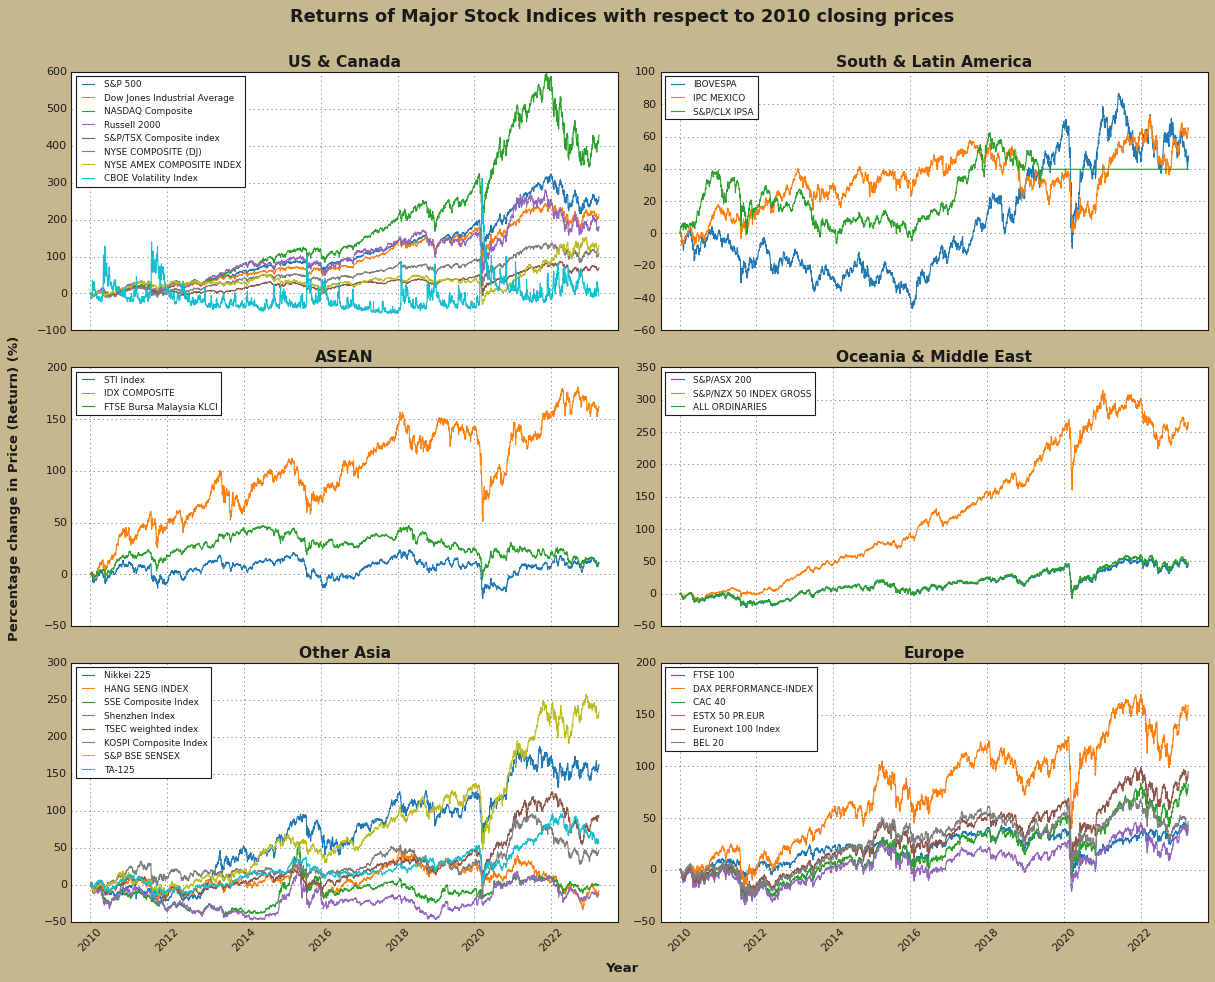

In [434]:
ref_year = min(df_refReturn.index).strftime('%Y')
max_colors = max(len(x) for x in region_idx2.values())
time_plot1 = minDate - relativedelta(months=6)
time_plot2 = time_end + relativedelta(months=6)
cmap = cm.get_cmap('tab10', max_colors)
color_list = []
for i in range(cmap.N):
    color_list.append(mpl.colors.rgb2hex(cmap(i))) # hex codes for coloring

#plt.style.use('_mpl-gallery')
# Create subplot
fig, axes = plt.subplots(len(region_idx2)//2,2, figsize=(15, 12), sharex=True)

# Iterate for each region
for i, region in enumerate(region_idx2.keys()):
    # Iterate for each subplot
    ax = axes[int(i/2), int(i%2)]
    for j, ticker in enumerate(region_idx2[region]):
        # Iterate and plot for each stock index in this region
        ax.plot(df_refReturn.index, df_refReturn[ticker], marker='', linewidth=1, color = color_list[j])
        ax.legend([ticker_name[t] for t in region_idx2[region]], loc='upper left', fontsize=8)
        ax.set_title(region, fontweight='bold', fontsize=14)
        ax.set_xlim([time_plot1,time_plot2])
        ax.tick_params(axis="x", rotation=45)
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(10)
            
#plt.xticks(rotation=-45, ha='left')
fig.patch.set_facecolor('#C7B78E')
fig.text(0.5,0, "Year", ha="center", va="center", fontweight ="bold", fontsize=12)
fig.text(0,0.5, "Percentage change in Price (Return) (%)\n", ha="center", va="center", rotation=90, fontweight ="bold", fontsize=12)
fig.suptitle("Returns of Major Stock Indices with respect to " + ref_year + " closing prices", fontweight ="bold", y=1, fontsize=16)
fig.tight_layout()


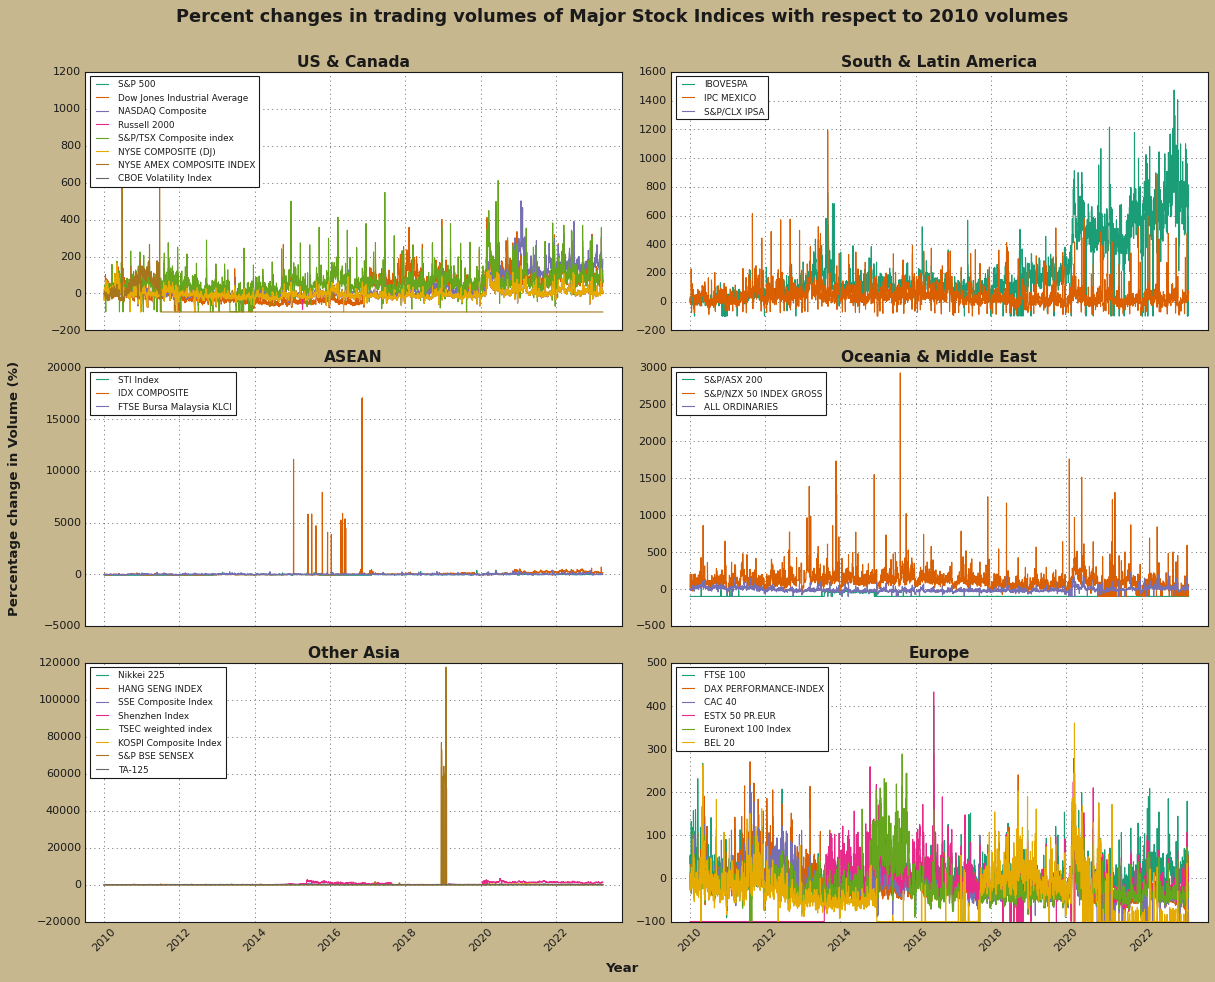

In [433]:
# Time series of volume change
cmap2 = cm.get_cmap('Dark2', max_colors)
color_list2 = []
for i in range(cmap2.N):
    color_list2.append(mpl.colors.rgb2hex(cmap2(i))) # hex codes for coloring

#plt.style.use('_mpl-gallery')
fig, axes = plt.subplots(len(region_idx2)//2,2, figsize=(15, 12), sharex=True)

for i, region in enumerate(region_idx2.keys()):
# Iterate for each region
    ax = axes[int(i/2), int(i%2)]
    for j, ticker in enumerate(region_idx2[region]):
        # Iterate and plot for each stock index in this region
        ax.plot(df_refVolChg.index, df_refVolChg[ticker], marker='', linewidth=1, color = color_list2[j])
        ax.legend([ticker_name[t] for t in region_idx2[region]], loc='upper left', fontsize=8)
        ax.set_title(region, fontweight='bold', fontsize=14)
        ax.set_xlim([time_plot1,time_plot2])
        ax.tick_params(axis="x", rotation=45)
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(10)
            
#plt.xticks(rotation=-45, ha='left')
fig.text(0.5,0, "Year", ha="center", va="center", fontweight ="bold", fontsize=12)
fig.text(0,0.5, "Percentage change in Volume (%)\n", ha="center", va="center", rotation=90, fontweight ="bold", fontsize=12)
fig.patch.set_facecolor('#C7B78E')
fig.suptitle("Percent changes in trading volumes of Major Stock Indices with respect to " + ref_year + " volumes", fontweight ="bold", y=1, fontsize=16)
fig.tight_layout()

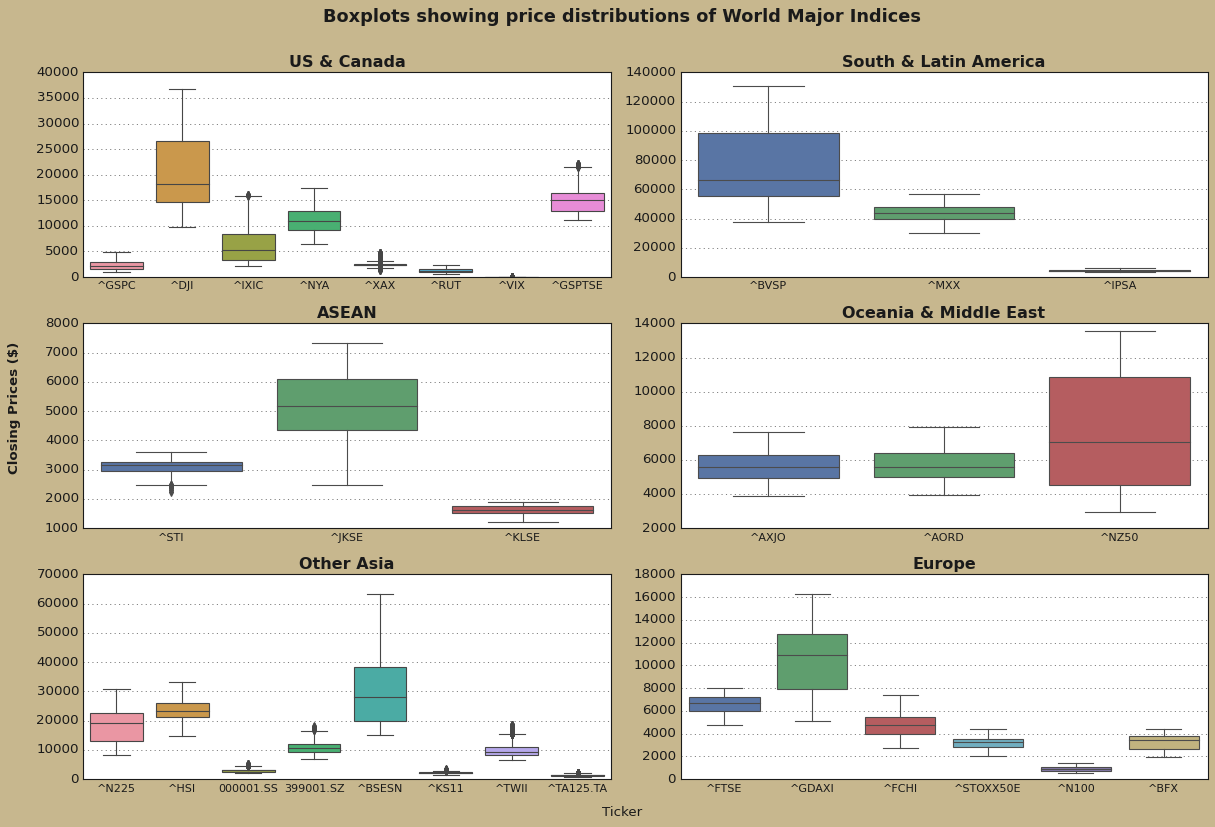

In [432]:
#plt.style.use('_mpl-gallery')
fig, axes = plt.subplots(nrows=len(region_idx2)//2, ncols=2, figsize=(15, 10)) # Adjust figure size as needed

axes = axes.flatten()

for i, region in enumerate(region_idx2.keys()):
    sns.boxplot(x='Ticker', y='Close', data=df_tickers2[df_tickers2['Region']==region], ax=axes[i])
    axes[i].set_title(region, fontweight='bold') # Set title for each subplot
    #axes[i].legend(loc='upper left', fontsize=8)
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=10)

fig.text(0.5, -0.01, 'Ticker', ha='center')
fig.text(0,0.5, "Closing Prices ($)\n", ha="center", va="center", rotation=90, fontweight ="bold", fontsize=12)
fig.suptitle("Boxplots showing price distributions of World Major Indices", fontweight ="bold", y=1, fontsize=16)
fig.patch.set_facecolor('#C7B78E')
fig.tight_layout() # Adjust subplot spacing


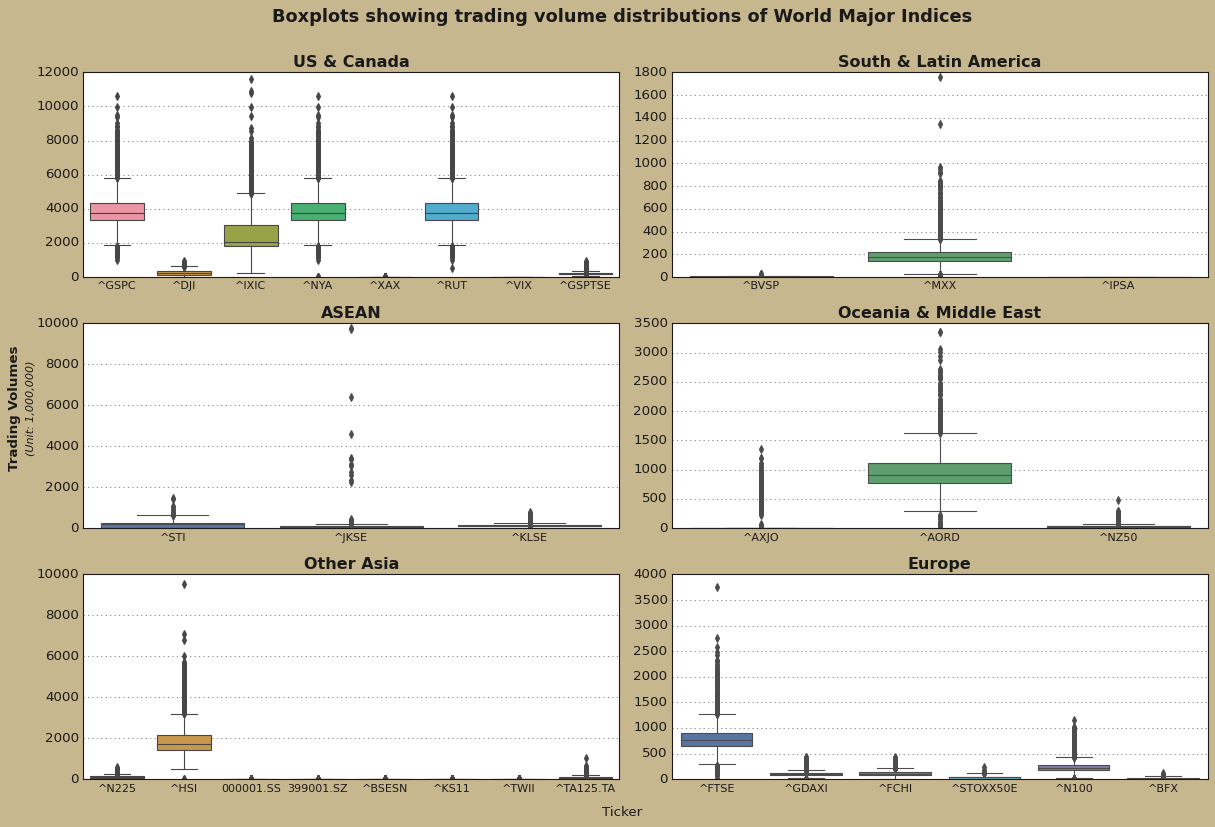

In [431]:
#plt.style.use('_mpl-gallery')
fig, axes = plt.subplots(nrows=len(region_idx2)//2, ncols=2, figsize=(15, 10)) # Adjust figure size as needed

axes = axes.flatten()

for i, region in enumerate(region_idx2.keys()):
    plot_region = df_tickers2[df_tickers2['Region']==region]
    sns.boxplot(x=plot_region['Ticker'], y=plot_region['Volume']/1000000, data=plot_region, ax=axes[i])
    axes[i].set_title(region, fontweight='bold') # Set title for each subplot
    #axes[i].legend(loc='upper left', fontsize=8)
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=10)

# set the x-axis label
fig.text(0.5, -0.01, 'Ticker', ha='center')
fig.text(0,0.5, "Trading Volumes\n", ha="center", va="center", rotation=90, fontweight ="bold", fontsize=12)
fig.text(0.012,0.5, "(Unit: 1,000,000)\n", ha="center", va="center", rotation=90, fontstyle ="italic", fontsize=10)
fig.suptitle("Boxplots showing trading volume distributions of World Major Indices", fontweight ="bold", y=1, fontsize=16)
fig.patch.set_facecolor('#C7B78E')
fig.tight_layout() # Adjust subplot spacing


In [53]:
# Calculate annualized return (252 trading days)
ann_returns = (1+df_dayReturn.mean(skipna=True))**252-1
ann_returns

Ticker
000001.SS    0.042310
399001.SZ    0.033785
^AORD        0.025330
^AXJO        0.028531
^BFX         0.023170
^BSESN       0.090163
^BVSP        0.018351
^DJI         0.081123
^FCHI        0.042472
^FTSE        0.051499
^GDAXI       0.085662
^GSPC        0.087535
^GSPTSE      0.035443
^HSI        -0.030644
^IPSA       -0.152548
^IXIC        0.133134
^JKSE        0.027778
^KLSE       -0.069192
^KS11       -0.017282
^MXX         0.081221
^N100        0.044776
^N225        0.088760
^NYA         0.035642
^NZ50        0.119167
^RUT         0.071866
^STI        -0.030018
^STOXX50E   -0.000060
^TA125.TA    0.104097
^TWII        0.116921
^VIX         7.524168
^XAX         0.045055
dtype: float64

In [54]:
# Calculate covariance of daily returns between tickers
cov_idx = df_dayReturn.cov()*252
cov_idx.iloc[0:5,0:5]
#cov_idx

Ticker     000001.SS  399001.SZ     ^AORD     ^AXJO      ^BFX
Ticker                                                       
000001.SS   0.051572   0.059206  0.010395  0.010196  0.008676
399001.SZ   0.059206   0.078387  0.012191  0.011940  0.010581
^AORD       0.010395   0.012191  0.025612  0.025935  0.012030
^AXJO       0.010196   0.011940  0.025935  0.026541  0.012066
^BFX        0.008676   0.010581  0.012030  0.012066  0.036322

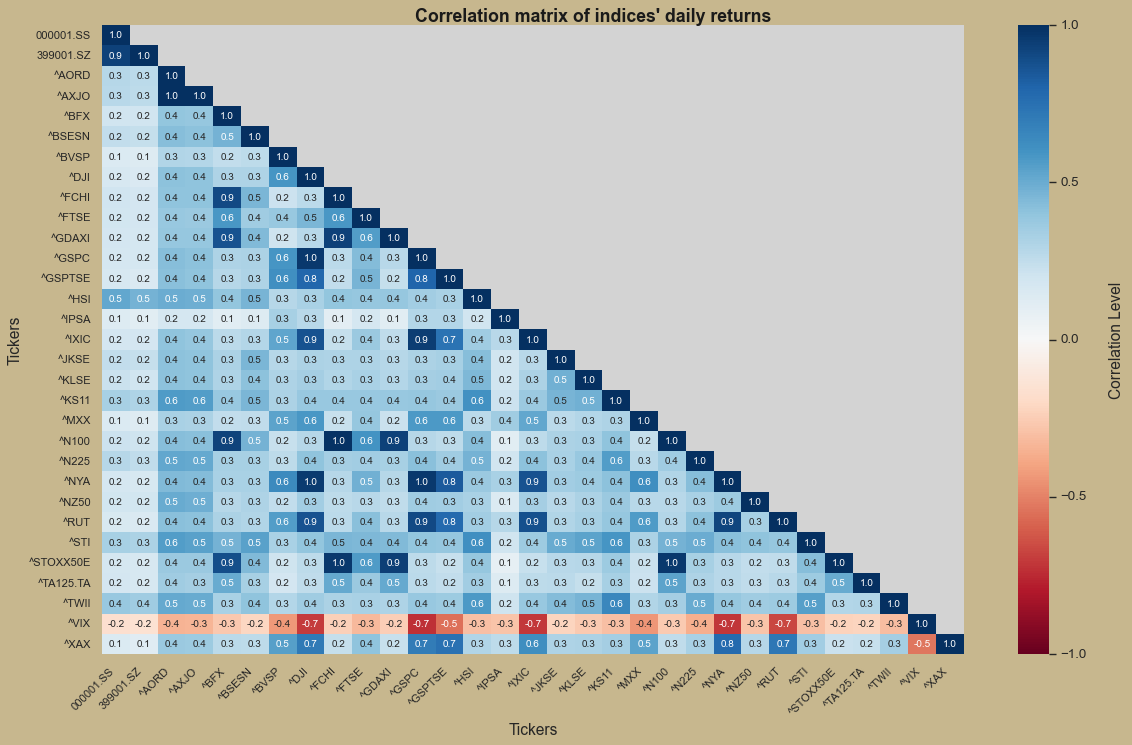

In [55]:
# Calculate the pearson correlation coefficient between indices
idx_corr = df_dayReturn.corr(method='pearson')
#idx_corr = idx_corr[(abs(idx_corr) >= 0.7) & (abs(idx_corr) < 1)]

# Create heatmap to visualize correlation matrix for indices
#plt.style.use('classic')
fig = plt.figure(figsize=(15,10))
fig.suptitle("Correlation matrix of indices' daily returns\n", y=0.93, fontsize = 16, fontweight ="bold")
sns.set(font_scale=0.8)
sns.set_theme(style='white')
g = sns.heatmap(idx_corr, annot=True, cmap="RdBu", annot_kws={"fontsize":9},
                vmin=-1, vmax=1, fmt='.1f', mask=np.triu(idx_corr, k=1))

# Set color bar title
g.collections[0].colorbar.set_label("\nCorrelation Level", fontsize=14)

# Set the label size
g.collections[0].colorbar.ax.tick_params(labelsize=12)

# Set axis titles
g.set_xlabel("Tickers", fontsize=14)
g.set_ylabel("Tickers", fontsize=14)
g.set_facecolor('lightgray')

#plt.text(16, -0.35, "(0.7 <= Absolute correlation < 1)", ha="center", va="center", fontsize=12, fontstyle ="italic")
xticks = g.set_xticklabels(g.get_xticklabels(), fontsize=10, rotation=45, ha='right') 
yticks = g.set_yticklabels(g.get_yticklabels(), fontsize=10)

fig.patch.set_facecolor('#C7B78E')
fig.tight_layout()

## III. Efficient Frontier Simulation
<a id='simulation'></a>
[Return to Table of Contents](#TOC)

In [56]:
def mean_variance(df_dayReturn, n_indices, n_portfolios, max_return=None, random_seed=99):
    """
    Function that takes input:
        The df of indices daily returns (tickers as columns, date as index, returns as value)
        The number of indices in each portfolio
        The number of portfolios to simulate
        The maximum return constraint for each simulated portfolio
        Seeding for numpy randomizer
    Output a df with 5 columns
    (expReturn, expVariance, Sharpe Ratio, portfolio assets, asset weights)
    """
    # Calculate annualized returns for all indices
    ann_returns = (1 + df_dayReturn.mean(skipna=True))**252 - 1
    
    # Calculate covariances between all indices
    cov_idx = df_dayReturn.cov()*252
    
    # Set random generator
    np.random.seed(random_seed)
    
    # Initialize empty df to store mean-variance of portfolio
    df_mean_var = pd.DataFrame(columns=['expReturn','expVariance','weights','tickers'])

    # Initialize counter for number of valid portfolios
    num_valid_portfolios = 0

    # Loop through and generate lots of random portfolios
    while num_valid_portfolios < n_portfolios:
        # Choose assets randomly without replacement
        assets = np.random.choice(list(df_dayReturn.columns), n_indices, replace=False)
        
        # Choose weights randomly
        weights = np.random.rand(n_indices)
        
        # Ensure weights sum to 1
        weights = weights/sum(weights)
        
        # Initialize values of Return & Variance
        portfolio_expReturn = 0
        portfolio_expVariance = 0
        
        for i in range(n_indices):
            # Port return = sumproduct(weights, asset return)
            portfolio_expReturn += weights[i] * ann_returns.loc[assets[i]]
            #portfolio_expReturn += weights[i] * ann_returns.iloc[i]
            
            for j in range(n_indices):
                # Port var = sumproduct(weight1, weight2, Cov(asset1,asset2))
                portfolio_expVariance += weights[i] * weights[j] * cov_idx.loc[assets[i], assets[j]]
                #portfolio_expVariance += weights[i] * weights[j] * cov_idx.iloc[i,j]
        
        # Check if portfolio_expReturn is less than or equal to max_return
        if max_return == None:
            df_mean_var.loc[num_valid_portfolios] = [portfolio_expReturn] + [portfolio_expVariance] + [weights] + [assets]
            num_valid_portfolios += 1
            
        elif portfolio_expReturn <= max_return:
            # Append values of returns, variances, weights and assets to df
            df_mean_var.loc[num_valid_portfolios] = [portfolio_expReturn] + [portfolio_expVariance] + [weights] + [assets]
            num_valid_portfolios += 1
            
        else:
            continue
    
    # Sharpe Ratio = (portfolio return - risk-free return) / (std.dev of portfolio return)
    df_mean_var['Sharpe_Ratio'] = (df_mean_var['expReturn'] - treasury_10y)/(df_mean_var['expVariance']**0.5)
            
    return df_mean_var

In [96]:
%%time
df_simulation = mean_variance(df_dayReturn, n_indices=6, max_return=None, n_portfolios=4000)
df_simulation.head()

Wall time: 11.7 s


expReturn  expVariance                                            weights  \
0   0.087336     0.025239  [0.03365724193409071, 0.2924133478740265, 0.07...   
1   0.042455     0.023095  [0.22322278101597096, 0.23277463024700473, 0.0...   
2   0.063555     0.018420  [0.005692668121690611, 0.11275324161160231, 0....   
3   0.109818     0.019819  [0.15572324907516163, 0.12332999742330888, 0.1...   
4   0.048253     0.023182  [0.12702730390948908, 0.3882075247593874, 0.08...   

                                             tickers  Sharpe_Ratio  
0       [^NYA, ^MXX, ^STOXX50E, ^RUT, ^GDAXI, ^IXIC]      0.329808  
1             [^BFX, ^JKSE, ^DJI, ^RUT, ^BVSP, ^XAX]      0.049453  
2          [^IPSA, ^AORD, ^XAX, ^N100, ^JKSE, ^IXIC]      0.210836  
3    [^N225, ^TA125.TA, ^TWII, ^IXIC, ^NZ50, ^BSESN]      0.531878  
4  [^GDAXI, ^STOXX50E, ^AXJO, ^IPSA, ^GSPC, ^TA12...      0.087436

In [97]:
df_simulation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   expReturn     4000 non-null   float64
 1   expVariance   4000 non-null   float64
 2   weights       4000 non-null   object 
 3   tickers       4000 non-null   object 
 4   Sharpe_Ratio  4000 non-null   float64
dtypes: float64(3), object(2)
memory usage: 187.5+ KB


In [517]:
# Calculate value at risk at given investment amount, confidence level and number of periods (days)
def val_at_risk(df, initial_inv=1, conf_level=0.95, periods=1, append=False):
    
    # Initialize empty list
    val_at_risk = []
    
    # Using SciPy ppf method to generate values for the inverse cumulative distribution function to a normal distribution
    # Plugging in the mean, standard deviation of our portfolio as calculated above
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
    alpha = 1 - conf_level
    for i in range(len(df)):
        
        # Calculate daily returns from annualized returns
        return_period = df['expReturn'].iloc[i]*periods/252
        variance_period = df['expVariance'].iloc[i]*periods/252
        
        # Calculate average investment amount based on annualized return
        mean_inv = (1+return_period) * initial_inv
        
        # Calculate potential return (left-tailed value) at probability of alpha (5% by default)
        cutoff1 = norm.ppf(alpha, mean_inv, variance_period**0.5)

        # Finally, we can calculate the VaR at our confidence interval
        # VaR = intial investment - return @ 5% prob.
        var_1p = initial_inv - cutoff1
        
        # Calculate var after n periods
        var_np = var_1p * np.sqrt(periods)
        
        # Append to list
        val_at_risk.append(var_np)
    
    # Whether to append results to the input dataframe
    if append==True:
        name = 'VaR_' + str(periods) + 'd'
        df[name] = val_at_risk
        return df
    else:
        return val_at_risk


In [522]:
# Calculate VaR 1 day with $1M investment
df_simulation = val_at_risk(df_simulation, initial_inv=1000000, append=True)
df_simulation

expReturn  expVariance  \
0      0.087336     0.025239   
1      0.042455     0.023095   
2      0.063555     0.018420   
3      0.109818     0.019819   
4      0.048253     0.023182   
...         ...          ...   
3995   0.676907     0.017732   
3996   0.044231     0.013827   
3997   0.058234     0.017154   
3998   0.029604     0.019453   
3999   0.076834     0.019170   

                                                weights  \
0     [0.03365724193409071, 0.2924133478740265, 0.07...   
1     [0.22322278101597096, 0.23277463024700473, 0.0...   
2     [0.005692668121690611, 0.11275324161160231, 0....   
3     [0.15572324907516163, 0.12332999742330888, 0.1...   
4     [0.12702730390948908, 0.3882075247593874, 0.08...   
...                                                 ...   
3995  [0.25389153000211906, 0.07005526239569398, 0.2...   
3996  [0.352743941247057, 0.03127011805776204, 0.266...   
3997  [0.05194475248322187, 0.2110385033716355, 0.25...   
3998  [0.2136634955365144, 0.0787392004286043, 0.066...   
3999  [0.1711671846931455, 0.17997301511816305, 0.09...   

                                                tickers  Sharpe_Ratio  \
0          [^NYA, ^MXX, ^STOXX50E, ^RUT, ^GDAXI, ^IXIC]      0.329808   
1                [^BFX, ^JKSE, ^DJI, ^RUT, ^BVSP, ^XAX]      0.049453   
2             [^IPSA, ^AORD, ^XAX, ^N100, ^JKSE, ^IXIC]      0.210836   
3       [^N225, ^TA125.TA, ^TWII, ^IXIC, ^NZ50, ^BSESN]      0.531878   
4     [^GDAXI, ^STOXX50E, ^AXJO, ^IPSA, ^GSPC, ^TA12...      0.087436   
...                                                 ...           ...   
3995         [^BSESN, ^NZ50, ^FCHI, ^IPSA, ^KS11, ^VIX]      4.820908   
3996          [^JKSE, ^HSI, ^NZ50, ^STI, ^GSPTSE, ^XAX]      0.079014   
3997  [^AORD, 000001.SS, ^GSPC, ^STOXX50E, ^GDAXI, ^...      0.177857   
3998        [^STOXX50E, ^KLSE, ^JKSE, ^BFX, ^NYA, ^DJI]     -0.038260   
3999         [^NZ50, ^IXIC, ^GDAXI, ^FCHI, ^N100, ^XAX]      0.302585   

           VaR_1d  
0     -346.555121  
1     -168.457675  
2     -252.187374  
3     -435.769611  
4     -191.463432  
...           ...  
3995 -2686.126366  
3996  -175.508567  
3997  -231.074459  
3998  -117.460858  
3999  -304.883930  

[4000 rows x 6 columns]

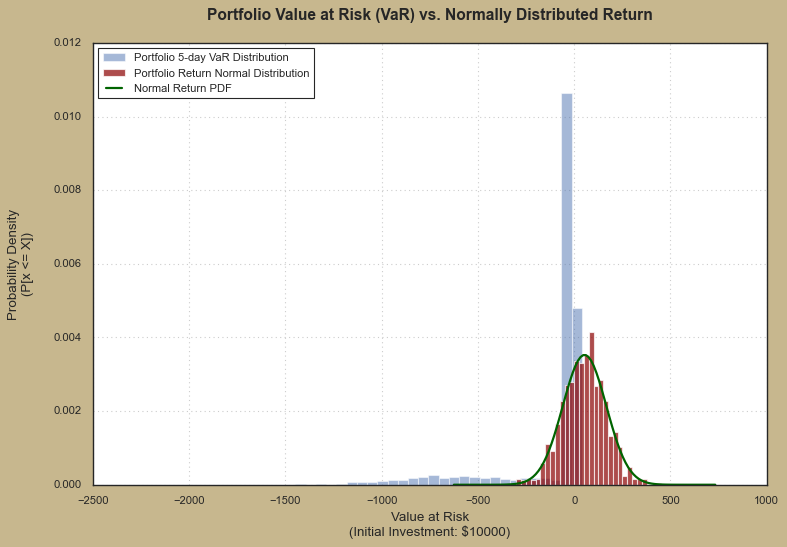

In [534]:
initial_inv = 10000
periods=5
# Plot Portfolio Value at Risk, Return and normal distribution
fig, ax = plt.subplots(figsize=(10,7))

#total_return = mean_return * 4/252 * investment
mean_return = df_simulation['expReturn']*initial_inv*periods/252
#ax.hist(mean_return, bins=40, histtype="bar", alpha=0.5, density=True, log=True, label='Portfolio Returns')
ax.hist(val_at_risk(df_simulation, initial_inv=initial_inv, periods=periods), 
        bins=40, histtype="bar", alpha=0.5, density=True, log=False, label='Portfolio ' + str(periods) + '-day VaR Distribution')

# generate random data following normal distribution of return
data = np.random.normal(mean_return.mean(), mean_return.std(), 1000)
# plot histogram
ax.hist(data, bins=30, density=True, log=False, alpha=0.7, color='darkred', label='Portfolio Return Normal Distribution')

# Plot normal PDF
x = np.linspace(mean_return.mean() - 6*mean_return.std(), 
                mean_return.mean() + 6*mean_return.std(),100)

ax.plot(x, norm.pdf(x, mean_return.mean(), mean_return.std()), linewidth=2, color='darkgreen', label='Normal Return PDF')

ax.set_title("Portfolio Value at Risk (VaR) vs. Normally Distributed Return\n", fontweight='bold', fontsize=14)
ax.set_xlabel('Value at Risk\n' + '(Initial Investment: $' + str(initial_inv) + ')')
ax.set_ylabel('Probability Density\n(P[x <= X])\n')
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.grid(linestyle='dotted')
#ax.set_facecolor('lightgray')
ax.legend(loc='best', fontsize=10)
fig.patch.set_facecolor('#C7B78E')
fig.tight_layout()

In [59]:
# Highest risk portfolio
df_maxrisk = df_simulation.sort_values(by=['expVariance'], ascending=True).head(1)

# Lowest risk portfolio
df_minrisk = df_simulation.sort_values(by=['expVariance']).head(1)
print("Annualized Return:", df_minrisk['expReturn'].iloc[0])
print("Annualized Risk:", df_minrisk['expVariance'].iloc[0]**0.5)
print("Sharpe Ratio:", df_minrisk['Sharpe_Ratio'].iloc[0])

df_minrisk_port = pd.DataFrame({'tickers': df_minrisk['tickers'].iloc[0], 'weights': df_minrisk['weights'].iloc[0]})
df_minrisk_port

Annualized Return: 0.445595043823475
Annualized Risk: 0.08813996009556704
Sharpe Ratio: 4.659124462931829


tickers   weights
0    ^MXX  0.163399
1   ^GSPC  0.255707
2   ^KS11  0.229768
3    ^HSI  0.057144
4   ^NZ50  0.242582
5    ^VIX  0.051402

In [60]:
# Lowest return portfolio
df_minreturn = df_simulation.sort_values(by=['expReturn']).head(1)

# Highest return portfolio
df_maxreturn = df_simulation.sort_values(by=['expReturn'], ascending=False).head(1)
print("Annualized Return:", df_maxreturn['expReturn'].iloc[0])
print("Annualized Risk:", df_maxreturn['expVariance'].iloc[0]**0.5)
print("Sharpe Ratio:", df_maxreturn['Sharpe_Ratio'].iloc[0])

df_maxreturn_port = pd.DataFrame({'tickers': df_maxreturn['tickers'].iloc[0], 'weights': df_maxreturn['weights'].iloc[0]})
df_maxreturn_port

Annualized Return: 4.7005071571058705
Annualized Risk: 0.8315283914893761
Sharpe Ratio: 5.610833262312122


tickers   weights
0     ^GDAXI  0.031437
1  000001.SS  0.053100
2  399001.SZ  0.067859
3       ^BFX  0.120459
4       ^RUT  0.104757
5       ^VIX  0.622388

In [61]:
# Highest risk-adjusted return
df_maxadj = df_simulation.sort_values(by=['Sharpe_Ratio'], ascending=False).head(1)
print("Annualized Return:", df_maxadj['expReturn'].iloc[0])
print("Annualized Risk:", df_maxadj['expVariance'].iloc[0]**0.5)
print("Sharpe Ratio:", df_maxadj['Sharpe_Ratio'].iloc[0])

df_maxadj_port = pd.DataFrame({'tickers': df_maxadj['tickers'].iloc[0], 'weights': df_maxadj['weights'].iloc[0]})
df_maxadj_port

Annualized Return: 1.3229823767983546
Annualized Risk: 0.15954997547963848
Sharpe Ratio: 8.072971326669675


tickers   weights
0    ^XAX  0.093503
1    ^VIX  0.166973
2    ^HSI  0.048562
3    ^DJI  0.331215
4   ^GSPC  0.237728
5   ^IXIC  0.122019

In [313]:
special_port = pd.concat([df_minrisk, df_maxreturn, df_maxadj], axis=0).reset_index(drop=True)
special_port['Name'] = ['Min Risk', 'Max Return', 'Max Sharpe Ratio']
special_port

expReturn  expVariance                                            weights  \
0   0.445595     0.007769  [0.163398529396743, 0.25570676408117554, 0.229...   
1   4.700507     0.691439  [0.031436632255486416, 0.053099825148709576, 0...   
2   1.322982     0.025456  [0.09350322471670151, 0.1669731794552226, 0.04...   

                                            tickers  Sharpe_Ratio  \
0           [^MXX, ^GSPC, ^KS11, ^HSI, ^NZ50, ^VIX]      4.659124   
1  [^GDAXI, 000001.SS, 399001.SZ, ^BFX, ^RUT, ^VIX]      5.610833   
2            [^XAX, ^VIX, ^HSI, ^DJI, ^GSPC, ^IXIC]      8.072971   

               Name  
0          Min Risk  
1        Max Return  
2  Max Sharpe Ratio

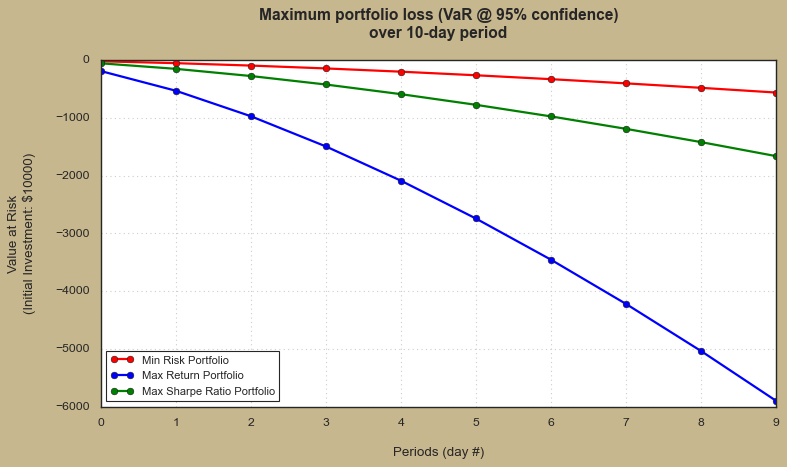

In [531]:
# Calculate n Day VaR
periods = 10
initial_inv= 10000
conf_level = 0.95

def var_periods(special_port, initial_inv, conf_level, periods=10, negative=False):
    
    # Create blank df to store data
    df_blank = pd.DataFrame(index=range(periods), columns= ['Min Risk', 'Max Return', 'Max Sharpe Ratio'])
    
    # Iterate over each portfolio
    for i in range(len(special_port)): 
        
        # Iterate over each period
        for j in range(periods):
            
            # Take each row of dataframe (each row = 1 portfolio)
            port = pd.DataFrame(special_port.loc[i]).T
            
            if negative==True:
                # Calculate the negative of VaR for different periods
                loss = [-n for n in val_at_risk(port, initial_inv=initial_inv, conf_level=conf_level, periods=j+1)]
            else:
                # Calculate the negative of VaR for different periods
                loss = [n for n in val_at_risk(port, initial_inv=initial_inv, conf_level=conf_level, periods=j+1)]
            
            # Store values in the dataframe
            df_blank.iloc[j,i] = loss[0]
            
    return df_blank

df_var = var_periods(special_port, initial_inv=initial_inv, conf_level=conf_level, periods=periods)

# Build plot
color_list = ['red', 'blue', 'green']
fig, ax = plt.subplots(figsize=(10,6))


ax.set_ylabel("Value at Risk\n(Initial Investment: $" + str(initial_inv) + ")\n")
ax.set_title("Maximum portfolio loss (VaR @ " + str(round(conf_level*100)) 
             + "% confidence)\nover " + str(periods) + "-day period\n", fontweight='bold', fontsize=14)

for i, j in enumerate(df_var.columns):
    
    if periods==1:
        new_columns = ['Min Risk', 'Max Sharpe Ratio', 'Max Return']
        ax.bar(x=new_columns[i] , height=df_var.reindex(columns=new_columns).iloc[:,i])
    else:
        ax.plot(df_var.iloc[:,i], label=j + ' Portfolio', color=color_list[i], linewidth=2, marker='o')

if periods>1:   
    ax.legend(loc="best", fontsize=10)
    ax.set_xlabel("\nPeriods (day #)")

ax.grid(linestyle='dotted')
fig.patch.set_facecolor('#C7B78E')
fig.tight_layout()

In [540]:
periods = 10
print("Average " + str(periods) + "-day VaR for all simulations is:", 
      np.mean(val_at_risk(df_simulation, initial_inv=initial_inv, periods=periods, conf_level=conf_level)))

Average 10-day VaR for all simulations is: -340.1841294253666


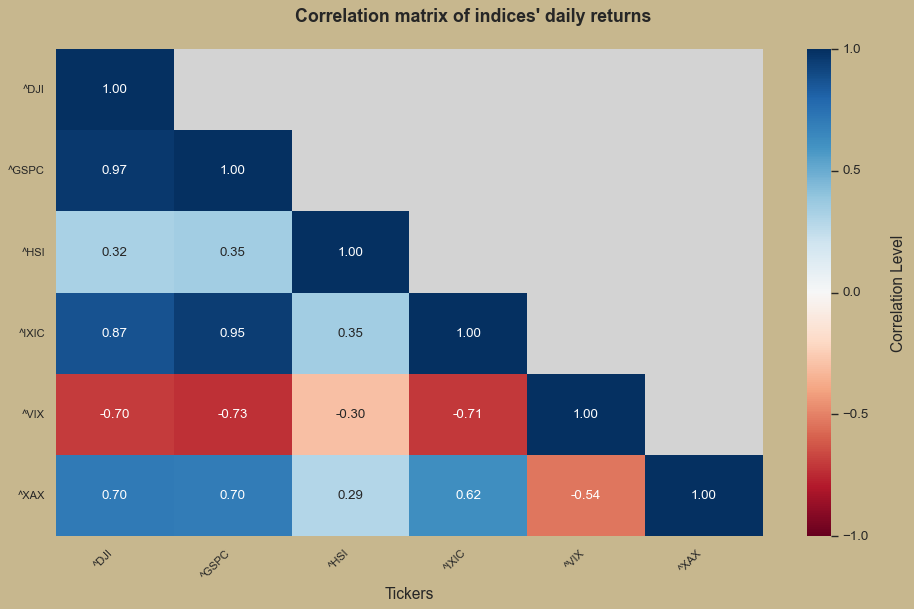

In [447]:
# Calculate the pearson correlation coefficient between indices
df_dayReturn_max = df_tickers2[df_tickers2['Ticker'].isin(list(df_maxadj_port['tickers']))]
df_dayReturn_max = rotate_df(df_dayReturn_max, 'Daily_Return')
idx_corr2 = df_dayReturn_max.corr(method='pearson')
#idx_corr = idx_corr[(abs(idx_corr) >= 0.7) & (abs(idx_corr) < 1)]

# Create heatmap to visualize correlation matrix for indices
#plt.style.use('classic')
fig = plt.figure(figsize=(12,8))
fig.suptitle("Correlation matrix of indices' daily returns\n", y=0.95, fontsize = 16, fontweight ="bold")
sns.set(font_scale=1)
sns.set_theme(style='white')
g = sns.heatmap(idx_corr2, annot=True, cmap="RdBu", annot_kws={"fontsize":12},
                vmin=-1, vmax=1, fmt='.2f', mask=np.triu(idx_corr2, k=1))

# Set color bar title
g.collections[0].colorbar.set_label("\nCorrelation Level", fontsize=14)

# Set the label size
g.collections[0].colorbar.ax.tick_params(labelsize=12)

# Set axis titles
g.set_xlabel("Tickers", fontsize=14)
g.set_ylabel("", fontsize=14)
g.set_facecolor('lightgray')

#plt.text(16, -0.35, "(0.7 <= Absolute correlation < 1)", ha="center", va="center", fontsize=12, fontstyle ="italic")
xticks = g.set_xticklabels(g.get_xticklabels(), fontsize=10, rotation=45, ha='right') 
yticks = g.set_yticklabels(g.get_yticklabels(), fontsize=10, rotation=0)
fig.patch.set_facecolor('#C7B78E')
plt.tight_layout()

In [63]:
# Define custom rounding function by decimals
def my_ceil(a, precision=0):
    return np.round(a + 0.5 * 10**(-precision), precision)

def my_floor(a, precision=0):
    return np.round(a - 0.5 * 10**(-precision), precision)

In [64]:
print(ply.io.templates)

Templates configuration
-----------------------
    Default template: 'streamlit'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none', 'streamlit']



In [65]:
# Create function to plot efficient frontier figure based on daily returns
def ef_plot(df, n_indices=6, n_portfolios=5000, max_return=None, width=1000, height=500):
    """
    Function that takes inputs: 
        the daily returns of assets, 
        number of assets per portfolio, 
        number of portfolios generated
        width and height of plot
    And outputs: 
        an efficient frontier plot based on portfolio returns and volatility
        add annotations & security market line
    """
    # Specify simulation settings
    df_simulation = mean_variance(df, n_indices=n_indices, max_return=max_return, n_portfolios=n_portfolios)

    # Highest risk portfolio
    df_maxrisk = df_simulation.sort_values(by=['expVariance'], ascending=False).head(1)

    # Lowest risk portfolio
    df_minrisk = df_simulation.sort_values(by=['expVariance']).head(1)

    # Lowest return portfolio
    df_minreturn = df_simulation.sort_values(by=['expReturn']).head(1)

    # Highest return portfolio
    df_maxreturn = df_simulation.sort_values(by=['expReturn'], ascending=False).head(1)

    # Highest risk-adjusted return
    df_maxadj = df_simulation.sort_values(by=['Sharpe_Ratio'], ascending=False).head(1)
    
    # Delta x and y of Security Market Line (SML)
    del_x = np.array([0, df_maxadj['expVariance'].iloc[0]**0.5])
    del_y = np.array([treasury_10y, df_maxadj['expReturn'].iloc[0]])

    # Calculate the slope of the security market line
    slope = np.polyfit(del_x, del_y, 1)[0]

    # Calculate the angle between the line and the x-axis
    my_angle = np.rad2deg(np.arctan(slope))
    
    # Furthest y-coord of point on SML 
    maxreturn_y = slope*(df_maxreturn['expVariance'].iloc[0]**0.5) + treasury_10y
    maxrisk_y = slope*(df_maxrisk['expVariance'].iloc[0]**0.5) + treasury_10y
    
    # Set position for the annotation above the SML
    x_mean = round(df_maxadj['expVariance'].iloc[0]**0.5/2,2)
    y_mean = my_ceil((df_maxadj['expReturn'].iloc[0] - treasury_10y)/2+treasury_10y,2)*1.1
    
    # Create efficient frontier figure
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_simulation['expVariance']**0.5, # x-axis = annualized std.dev (volatility) 
                             y=df_simulation['expReturn'],  # y-axis = annualized returns
                             # Add color scale for sharpe ratio 
                             marker=dict(color=df_simulation['Sharpe_Ratio'], 
                                         showscale=True,
                                         size=7,
                                         line=dict(width=1),
                                         colorscale="Agsunset",
                                         colorbar=dict(title="Sharpe<br>Ratio")
                                        ), 
                             mode='markers',
                             showlegend=False))

    # Plot Security Market Line (SML)
    fig.add_trace(go.Scatter(x=[0, df_maxrisk['expVariance'].iloc[0]**0.5], # [0, max Var-x]
                             y=[treasury_10y, maxrisk_y], # [rf rate, max Var-y]
                             # Add color scale for sharpe ratio 
                             line=dict(
                                 color='black',
                                 width=2,
                                 dash='solid'), 
                             mode='lines',
                             name='Security Market Line',
                             showlegend=True))
    # Plot risk-free rate
    fig.add_trace(go.Scatter(x=[0], 
                             y=[treasury_10y],
                             marker=dict(
                                 color='darkorange',
                                 size=12), 
                             mode='markers',
                             name='Risk-free Rate (' + str(round(treasury_10y*100,2)) + '%)',
                             showlegend=True))

    # Plot min risk port
    fig.add_trace(go.Scatter(x=df_minrisk['expVariance']**0.5,
                             y=df_minrisk['expReturn'],  
                             # Add color scale for sharpe ratio 
                             marker=dict(
                                 color='darkgreen',
                                 size=12), 
                             mode='markers',
                             name='Lowest Volatility Portfolio',
                             showlegend=True))

    # Plot max return ratio port
    fig.add_trace(go.Scatter(x=df_maxreturn['expVariance']**0.5, 
                             y=df_maxreturn['expReturn'], 
                             # Add color scale for sharpe ratio 
                             marker=dict(
                                 color='black',
                                 size=12), 
                             mode='markers',
                             name='Highest Return Portfolio',
                             showlegend=True))

    # Plot max shorpe ratio port
    fig.add_trace(go.Scatter(x=df_maxadj['expVariance']**0.5, 
                             y=df_maxadj['expReturn'], 
                             # Add color scale for sharpe ratio 
                             marker=dict(
                                 color='darkred',
                                 size=12), 
                             mode='markers',
                             name='Highest Sharpe Ratio Portfolio',
                             showlegend=True))

    # Plot max return line
    fig.add_hline(y=df_maxadj['expReturn'].iloc[0], line_width=2, 
                  line_dash="dot", line_color="darkblue")

    fig.add_hline(y=df_maxadj['expReturn'].iloc[0]*1.01, line_width=1, 
                  line_dash="dot", line_color="white",
                  annotation_text="<b>Highest Sharpe Ratio</b>", 
                  annotation_position="top right",
                  annotation_font_color="darkblue",
                  annotation_font_size=13)

    # Plot min var line
    fig.add_vline(x=df_minrisk['expVariance'].iloc[0]**0.5, line_width=2, 
                  line_dash="dot", line_color="darkblue")

    fig.add_vline(x=df_minrisk['expVariance'].iloc[0]**0.5*0.97, line_width=2, 
                  line_dash="dot", line_color="white",
                  annotation_text="<b>Lowest volatility<br></b>", 
                  annotation_position="top left",
                  annotation_font_color="darkblue",
                  annotation_font_size=13,
                  annotation_textangle=-90)

    # Plot risk-free line
    fig.add_vline(x=0, line_width=2, 
                  line_dash="dot", line_color="darkblue")

    fig.add_vline(x=-0.002, line_width=1, 
                  line_dash="dot", line_color="white",
                  annotation_text="<b>Risk-free line<br></b>", 
                  annotation_position="top left",
                  annotation_font_color="darkblue",
                  annotation_font_size=13,
                  annotation_textangle=-90)

    # Add text to SML
    # fig.add_annotation(x=x_mean,  # x-coordinate of the point to annotate
    #                    y=y_mean,  # y-coordinate of the point to annotate
    #                    text="<b>The Security Market Line</b>",
    #                    font=dict(color='darkred',size=13),
    #                    textangle=-my_angle,  # set the angle of the text to the calculated angle
    #                    xanchor='center',xref='x', yref='y',
    #                    showarrow=False,
    #                    arrowhead=0)

    # Add text below x axis
    fig.add_annotation(dict(font=dict(color='black',size=12),
                            x=0.5,
                            y=-0.23,
                            showarrow=False,
                            text="<i>Risk-free rate (10-yr US Treasury Yield) = " + str(round(treasury_10y*100,2)) + "%</i><br>",
                            textangle=0,
                            xanchor='center',
                            xref="paper",
                            yref="paper"))
    # Add title/labels
    fig.update_layout(template='simple_white',
                      xaxis=dict(title='Annualized Risk (Volatility)'),
                      #yaxis=dict(title='Annualized Return', scaleanchor="x", scaleratio=1),
                      yaxis=dict(title='Annualized Return'),
                      yaxis_range=[min(-1,-my_ceil(df_maxreturn['expReturn'].iloc[0])),my_ceil(df_maxreturn['expReturn'].iloc[0],2)*2],
                      #xaxis_range=[-1,1],
                      title='<b>Efficient Frontier - Simulations of ' + str(len(df_simulation)) + ' Random Portfolios</b><br><i>(each consists of ' 
                            + str(len(df_simulation['tickers'][0])) + ' indices)</i>',
                      title_x=0.5,
                      #xaxis_range=[0, my_ceil(df_maxrisk['expVariance'].iloc[0]**0.5,1)],
                      coloraxis_colorbar=dict(title="Sharpe Ratio (SR)"),
                      plot_bgcolor='rgb(240,240,240)',
                      legend=dict(
                          x=1,
                          y=0,
                          xanchor='right',
                          yanchor='bottom',
                          entrywidth=0,
                          entrywidthmode='pixels',
                          bgcolor='rgb(240,240,240)',
                          font=dict(color='black', size=10)),
                      #margin=dict(l=50, r=50, t=100, b=100),
                      width=width, height=height)

    fig.show()
    return

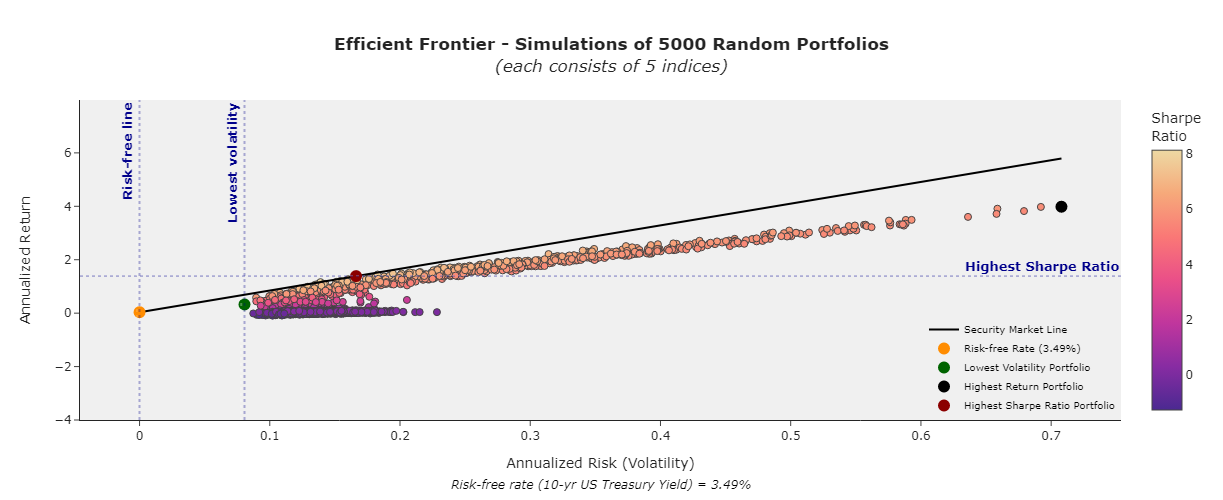

Wall time: 19.7 s


In [66]:
%%time
# Plot 5000 portfolios, each with 5 indices
ef_plot(df_dayReturn, n_indices=5, n_portfolios=5000)

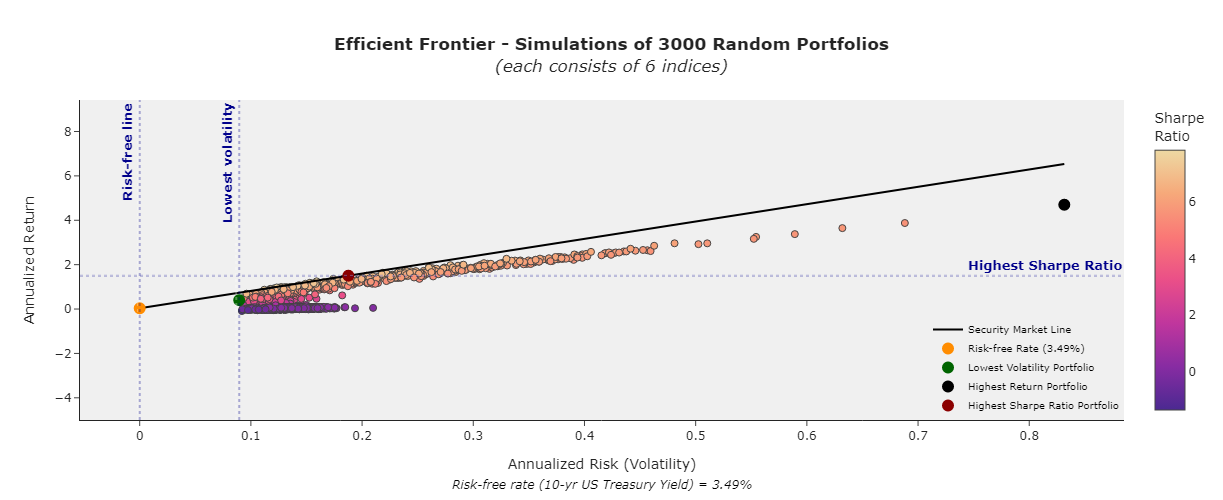

Wall time: 14.9 s


In [67]:
%%time
# Plot 3000 portfolios, each with 6 indices
ef_plot(df_dayReturn, n_indices=6, n_portfolios=3000)

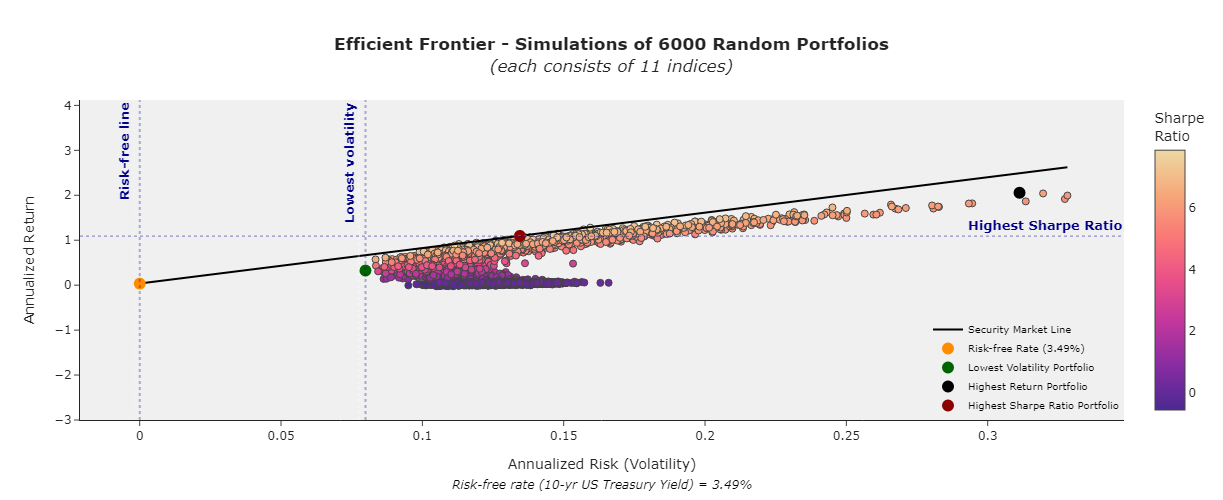

Wall time: 34.3 s


In [68]:
%%time
# Plot 6000 portfolios, each with 11 indices
ef_plot(df_dayReturn, n_indices=11, n_portfolios=6000)

## IV. Predicting Price of Stock Index
<a id='prediction'></a>

[Return to Table of Contents](#TOC)

In [69]:
# Pick one ticker to predict
pick_ticker = '^GSPC'
df_ticks = yf.Ticker(pick_ticker)

# Get name of ticker
ticker_chosen = ticker_name[pick_ticker]

# Get closing price of ticker
df_ticks = df_ticks.history(period='max')['Close'].reset_index()

# Convert Date to datetime and use as table index
df_ticks['Date'] = pd.to_datetime(pd.to_datetime(df_ticks['Date'], utc=True).dt.strftime('%Y-%m-%d'))
df_ticks = df_ticks.set_index(df_ticks['Date'])
df_ticks = df_ticks.drop('Date',axis=1)
df_ticks.head()

Close
Date                 
1927-12-30  17.660000
1928-01-03  17.760000
1928-01-04  17.719999
1928-01-05  17.549999
1928-01-06  17.660000

In [70]:
# Choose scaler
minmax_scaler = MinMaxScaler()
std_scaler = StandardScaler()

# Apply scaler
#scaled_data = minmax_scaler.fit_transform(df_ticks.values)
scaled_data = std_scaler.fit_transform(df_ticks.values)
scaled_data

array([[-0.61099907],
       [-0.61089044],
       [-0.6109339 ],
       ...,
       [ 3.83338732],
       [ 3.81493097],
       [ 3.87388514]])

In [71]:
# Split 80/20 and use scaled data as training data
train_rows = math.ceil(len(df_ticks)*.8)
df_train = scaled_data[0:train_rows]
df_test = scaled_data[train_rows:len(df_ticks)]

In [72]:
print(df_ticks.shape)
print(df_train.shape)
print(df_test.shape)

(23935, 1)
(19148, 1)
(4787, 1)


In [73]:
# Function that split a dataframe based on look_back value
def lookback_split(dataset, look_back=30):
    data_X, data_Y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        data_X.append(a)
        data_Y.append(dataset[i + look_back])
    return np.array(data_X), np.array(data_Y)

The lookback period in this case refers how many days in the past the prediction model will use as training data to predict closing price of the next day. In this case, you have chosen 30-day lookback period, meaning that the price of day 31 will be predicted based on prices from the previous 30 days

In [74]:
# Assuming df_train and df_test are 1D arrays of daily closing prices
pred_rows = 30
x_train, y_train = lookback_split(df_train, look_back=pred_rows)
x_test, y_test = lookback_split(df_test, look_back=pred_rows)

# Reshape arrays
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

In [75]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(19118, 30)
(19118,)
(4757, 30)
(4757,)


In [76]:
# Construct neural network using Multi-layer Perceptron regressor
model = MLPRegressor(hidden_layer_sizes=(20, 20), activation='relu', solver='adam', max_iter=1000, random_state=99)
model.fit(x_train, y_train)

MLPRegressor(hidden_layer_sizes=(20, 20), max_iter=1000, random_state=99)

In [77]:
# Create predictions
y_pred = model.predict(x_test)

# Inverse the scaling process and reshape arrays into columns
y_test = std_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = std_scaler.inverse_transform(y_pred.reshape(-1, 1))

In [78]:
def mape_score(y_true, y_pred):
    """
    Calculate the mean absolute percentage error (MAPE) between two arrays.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Show prediction scores
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
mape_test = mape_score(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

df_score = pd.DataFrame([{'RMSE': rmse_test, 'MAPE': mape_test, 'R_Squared': r2_test}]).T
df_score.columns = ['Model Score']
df_score

Model Score
RMSE        107.670116
MAPE          0.026959
R_Squared     0.988734

In [79]:
# Create df for plotting
train_price = df_ticks[:(train_rows+pred_rows)]
test_price = df_ticks[(train_rows+pred_rows):]
pred_price = pd.DataFrame(y_pred, columns=['Predictions'])
pred_price = pred_price.set_index(test_price.index)
pred_price['Close'] = y_test
pred_price

Predictions        Close
Date                                
2004-05-20  1097.632972  1089.189941
2004-05-21  1098.342898  1093.560059
2004-05-24  1094.829405  1095.410034
2004-05-25  1089.562795  1113.050049
2004-05-26  1096.737655  1114.939941
...                 ...          ...
2023-04-06  3855.214909  4105.020020
2023-04-10  3867.528953  4109.109863
2023-04-11  3860.326304  4108.939941
2023-04-12  3920.569191  4091.949951
2023-04-13  3933.784309  4146.220215

[4757 rows x 2 columns]

In [80]:
# Generate future predictions
def future_pred(x_test, days=5):
    
    # Take actual data from last 30 days
    x_recent = x_test[-1].reshape(1,-1)

    # Generate predictions for the next days+1
    predictions = []
    for i in range(days+1):    
        
        # Use the model to predict the next day's closing price
        pred = model.predict(x_recent)

        # Add the prediction to the list of predictions
        predictions.append(pred[0])

        # Update the input data with the new prediction
        x_recent = np.roll(x_recent, -1)
        x_recent[0, -1] = pred

    # Inverse the scaling process to obtain the actual predicted prices
    predictions = std_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    
    # Remove the first predictions since it overlaps with previous predictions
    predictions = predictions[1:days+1]
    
    return predictions

In [81]:
future_price = future_pred(x_test, 5)
future_price

array([[3878.32865357],
       [3893.99172724],
       [3904.16656903],
       [3887.90487896],
       [3848.12672852]])

In [82]:
# Set the last 5 values of the 'Prediction Price' column to the values in new_price
future_price = future_pred(x_test, 5)
new_price = future_price.reshape(-1)

# Get the last date in the DataFrame and compute the next 5 trading days
last_date = pred_price.index[-1]
next_dates = pd.date_range(last_date, periods=6, freq='B')

# Create new dataframe
pred_new = pd.DataFrame(index=next_dates, columns=pred_price.columns).tail(5)
pred_new['Predictions'] = new_price

# Set the values in the 'Closing Price' column to NaN for the last 5 rows
pred_price2 = pd.concat([pred_price, pred_new], axis=0)
pred_price2.tail(10)

Predictions        Close
2023-04-06  3855.214909  4105.020020
2023-04-10  3867.528953  4109.109863
2023-04-11  3860.326304  4108.939941
2023-04-12  3920.569191  4091.949951
2023-04-13  3933.784309  4146.220215
2023-04-14  3878.328654          NaN
2023-04-17  3893.991727          NaN
2023-04-18  3904.166569          NaN
2023-04-19  3887.904879          NaN
2023-04-20  3848.126729          NaN

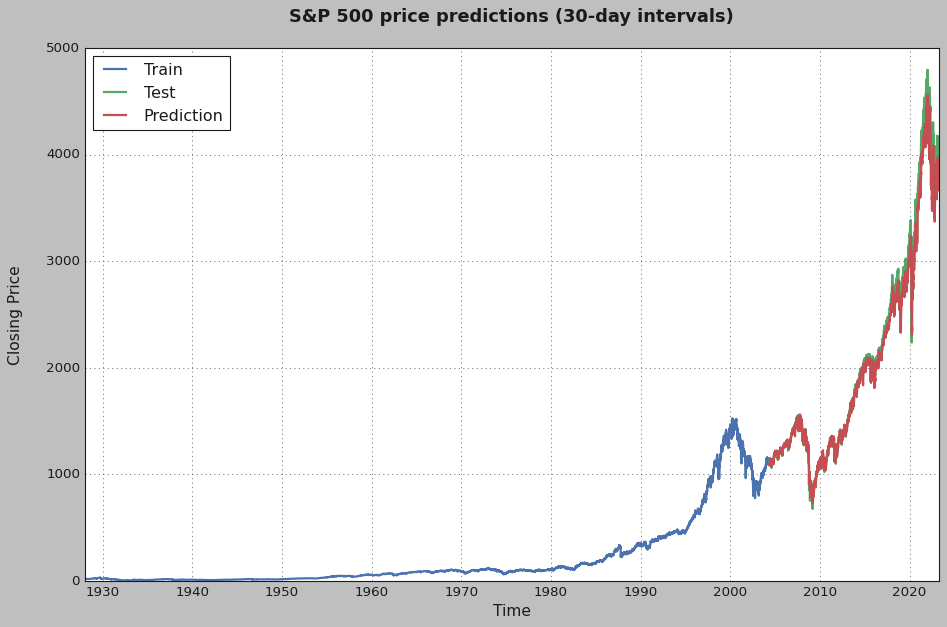

In [83]:
# Comparing predictions to testing prices
plt.style.use('classic')
plt.style.use('_mpl-gallery')
plt.figure(figsize=(12,8))
plt.plot(train_price['Close'],linewidth=2)
plt.plot(pred_price2[['Close','Predictions']],linewidth=2)

plt.title(ticker_chosen + ' price predictions (' + str(pred_rows) + '-day intervals)\n', fontsize=16, fontweight="bold")
plt.xlabel('Time', fontsize=14)
plt.ylabel('Closing Price\n', fontsize=14)
plt.legend(['Train','Test','Prediction'], loc='upper left')

plt.tight_layout()
plt.show()

## V. Code References
<a id='references'></a>
- https://towardsdatascience.com/efficient-frontier-in-python-detailed-tutorial-84a304f03e79
- https://towardsdatascience.com/analyzing-world-stock-indices-performance-in-python-610df6a578f
- https://www.interviewqs.com/blog/value-at-risk

[Return to Table of Contents](#TOC)